# Connect G-Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
myDirFiles = "/content/drive/MyDrive/Colab Notebooks/DigitalSkola/Week 9"
os.chdir(myDirFiles)

In [ ]:
!ls

 Assets		       Lin_reg_model.pkl
 data_collection.txt  '[Sandbox] House Price Prediction.ipynb'
 insurance.csv


# I.1 General Exploration

In [ ]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sklearn

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

warnings.filterwarnings("ignore")
%matplotlib inline
sns.set(rc={"figure.figsize": (20, 15)})
sns.set_style("whitegrid")

In [ ]:
# Load Train set
df_train = pd.read_csv("Assets/train.csv")
print(f"Train set shape:\n{df_train.shape}\n")

# Load Test set
df_test = pd.read_csv("Assets/test.csv")
print(f"Test set shape:\n{df_test.shape}")

Train set shape:
(1460, 81)

Test set shape:
(1459, 80)


In [ ]:
# info of each of the variables in our train set
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
# Checking if column headings are the same in both data set
dif_1 = [x for x in df_train.columns if x not in df_test.columns]
print(f"Columns present in df_train and absent in df_test: {dif_1}\n")

dif_2 = [x for x in df_test.columns if x not in df_train.columns]
print(f"Columns present in df_test set and absent in df_train: {dif_2}")

Columns present in df_train and absent in df_test: ['SalePrice']

Columns present in df_test set and absent in df_train: []


In [ ]:
# Drop the 'Id' column from the train set
df_train.drop(["Id"], axis=1, inplace=True)

# Save the list of 'Id' before dropping it from the test set
Id_test_list = df_test["Id"].tolist()
df_test.drop(["Id"], axis=1, inplace=True)

# I.2 Numerical Features

## I.2.1 Explore and Clean Numerical features

In [ ]:
# Let's select the columns of the train set with numerical data
df_train_num = df_train.select_dtypes(exclude=["object"])
df_train_num.head()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  WoodDeckSF  \
0          2003       196.0         706           0  ...           0   
1          1976         0.0         978           0  ...         298   
2          2002       162.0         486           0  ...           0   
3          1970         0.0         216           0  ...           0   
4          2000       350.0         655           0  ...         192   

   OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  \
0           61              0          0            0         0        0   
1            0              0          0            0         0        0   
2           42              0          0            0         0        0   
3           35            272          0            0         0        0   
4           84              0          0            0         0        0   

   MoSold  YrSold  SalePrice  
0       2    2008     208500  
1       5    2007     181500  
2       9    2008     223500  
3       2    2006     140000  
4      12    2008     250000  

[5 rows x 37 columns]

In [ ]:
# Let's drop quasi-constant features where 95% of the values are similar or constant
# sel : selector
sel = VarianceThreshold(threshold=0.05) # 0.05: drop column where 95% of the values are constant

# fit finds the features with constant variance
sel.fit(df_train_num.iloc[:, :-1]) # all cols except 'SalePrice'

VarianceThreshold(threshold=0.05)

In [ ]:
sel.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [ ]:
# Get the number of features that are not constant
print(f"Number of retained features: {sum(sel.get_support())}")
print(f"\nNumber of quasi_constant features: {len(df_train_num.iloc[:, :-1].columns) - sum(sel.get_support())}")

Number of retained features: 35

Number of quasi_constant features: 1


In [ ]:
df_train_num.iloc[:, :-1].columns[sel.get_support()]

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [ ]:
df_train_num.iloc[:, :-1].columns[~sel.get_support()]#siapa yang ga lolos seleksi

Index(['KitchenAbvGr'], dtype='object')

In [ ]:
# Notes!
# Example Case
myArr = np.array([1, 2, 3, 4])
myFilter = np.array([True, True, True, False])
myArr[myFilter]

array([1, 2, 3])

In [ ]:
myArr[~myFilter]

array([4])

In [ ]:
~myFilter

array([False, False, False,  True])

In [ ]:
quasi_constant_features_list = df_train_num.iloc[:, :-1].columns[~sel.get_support()].tolist()
print(f"\nQuasi-constant features to be dropped: {quasi_constant_features_list}")


Quasi-constant features to be dropped: ['KitchenAbvGr']


In [ ]:
df_train["KitchenAbvGr"].value_counts()

1    1392
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64

In [ ]:
# Let's drop these columns from df_train_num
df_train_num.drop(
    quasi_constant_features_list,
    axis=1,
    inplace=True
)

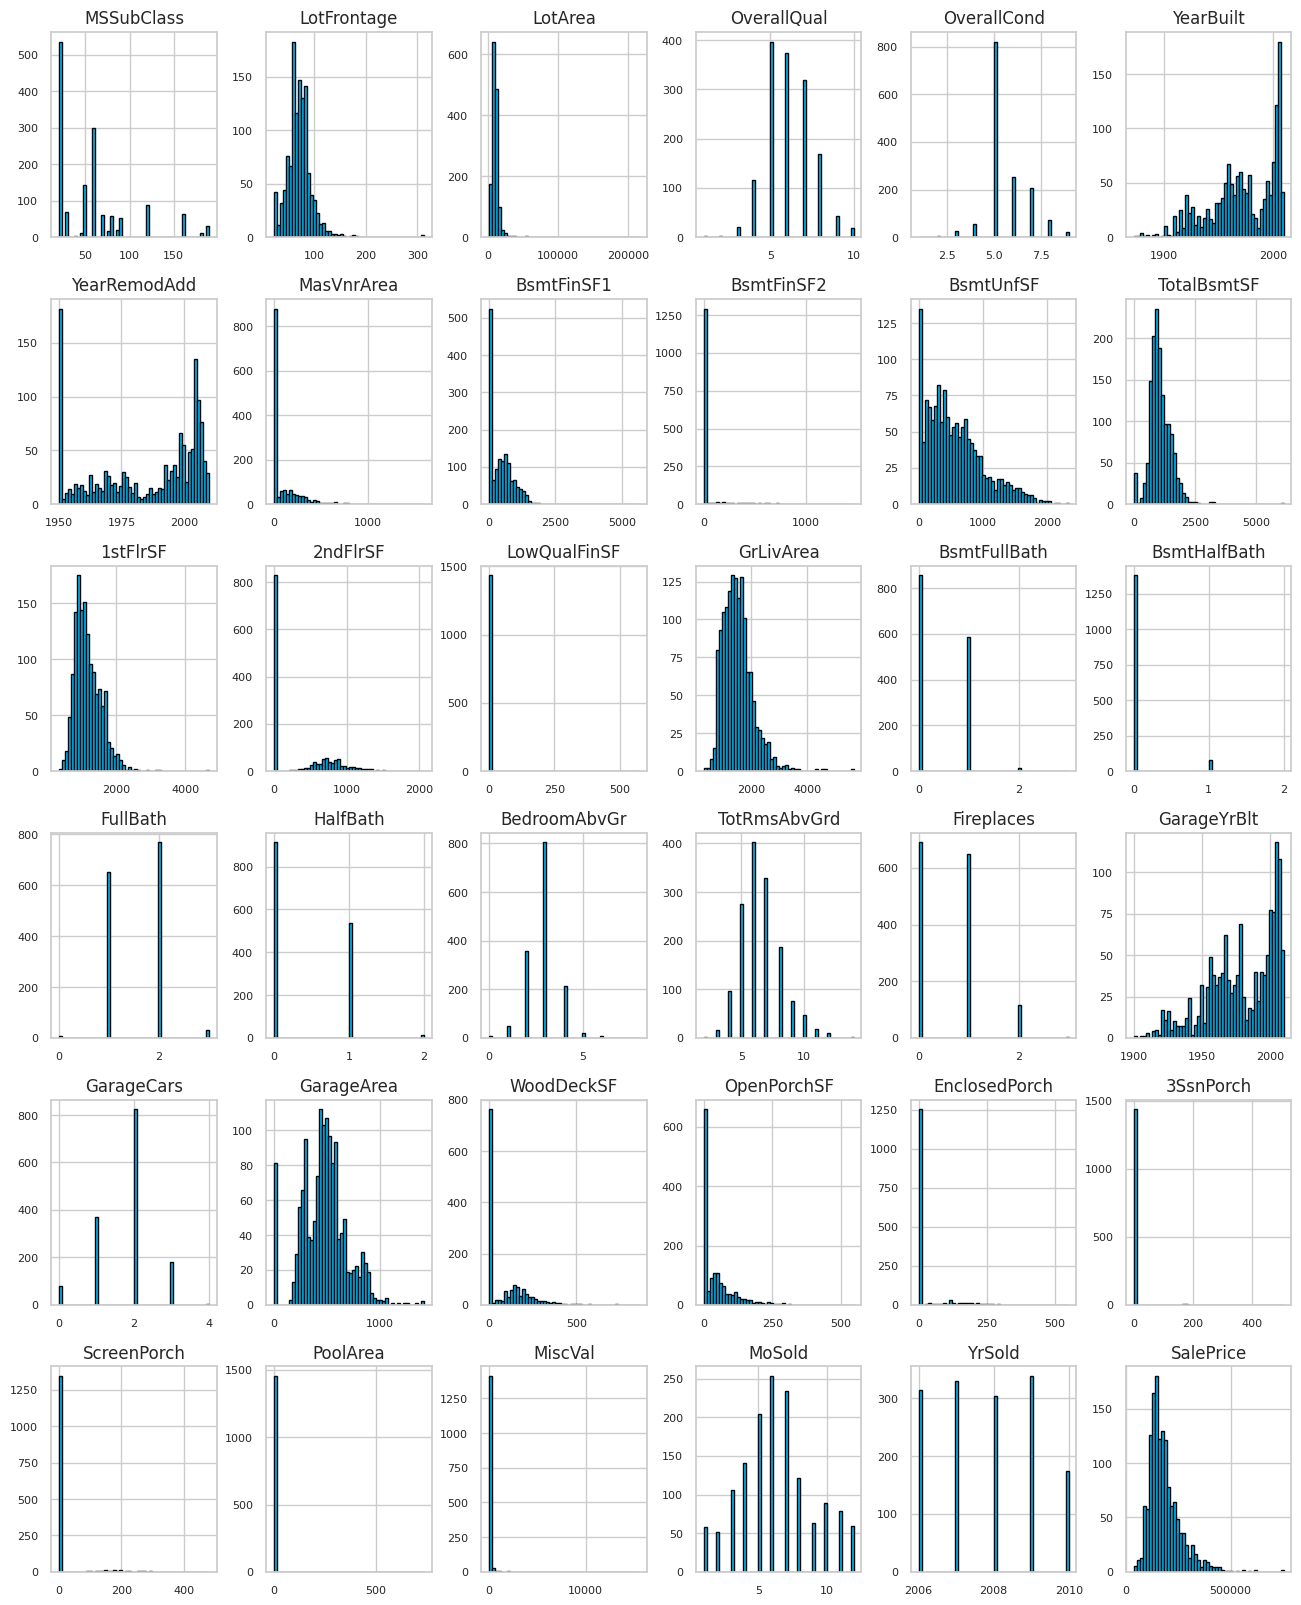

In [ ]:
# Plot the distribution of all the numerical data
fig_ = df_train_num.hist(
    figsize=(16, 20),
    bins=50,
    color="deepskyblue",
    edgecolor="black",
    xlabelsize=8,
    ylabelsize=8
)

In [ ]:
# Heatmap for all the remaining numerical data including the taget 'SalePrice'

# Define the heatmap parameters
pd.options.display.float_format = "{:,.2f}".format

In [ ]:
# Define correlation matrix
corr_matrix = df_train_num.corr()
corr_matrix

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
MSSubClass           1.00        -0.39    -0.14         0.03        -0.06   
LotFrontage         -0.39         1.00     0.43         0.25        -0.06   
LotArea             -0.14         0.43     1.00         0.11        -0.01   
OverallQual          0.03         0.25     0.11         1.00        -0.09   
OverallCond         -0.06        -0.06    -0.01        -0.09         1.00   
YearBuilt            0.03         0.12     0.01         0.57        -0.38   
YearRemodAdd         0.04         0.09     0.01         0.55         0.07   
MasVnrArea           0.02         0.19     0.10         0.41        -0.13   
BsmtFinSF1          -0.07         0.23     0.21         0.24        -0.05   
BsmtFinSF2          -0.07         0.05     0.11        -0.06         0.04   
BsmtUnfSF           -0.14         0.13    -0.00         0.31        -0.14   
TotalBsmtSF         -0.24         0.39     0.26         0.54        -0.17   
1stFlrSF            -0.25         0.46     0.30         0.48        -0.14   
2ndFlrSF             0.31         0.08     0.05         0.30         0.03   
LowQualFinSF         0.05         0.04     0.00        -0.03         0.03   
GrLivArea            0.07         0.40     0.26         0.59        -0.08   
BsmtFullBath         0.00         0.10     0.16         0.11        -0.05   
BsmtHalfBath        -0.00        -0.01     0.05        -0.04         0.12   
FullBath             0.13         0.20     0.13         0.55        -0.19   
HalfBath             0.18         0.05     0.01         0.27        -0.06   
BedroomAbvGr        -0.02         0.26     0.12         0.10         0.01   
TotRmsAbvGrd         0.04         0.35     0.19         0.43        -0.06   
Fireplaces          -0.05         0.27     0.27         0.40        -0.02   
GarageYrBlt          0.09         0.07    -0.02         0.55        -0.32   
GarageCars          -0.04         0.29     0.15         0.60        -0.19   
GarageArea          -0.10         0.34     0.18         0.56        -0.15   
WoodDeckSF          -0.01         0.09     0.17         0.24        -0.00   
OpenPorchSF         -0.01         0.15     0.08         0.31        -0.03   
EnclosedPorch       -0.01         0.01    -0.02        -0.11         0.07   
3SsnPorch           -0.04         0.07     0.02         0.03         0.03   
ScreenPorch         -0.03         0.04     0.04         0.06         0.05   
PoolArea             0.01         0.21     0.08         0.07        -0.00   
MiscVal             -0.01         0.00     0.04        -0.03         0.07   
MoSold              -0.01         0.01     0.00         0.07        -0.00   
YrSold              -0.02         0.01    -0.01        -0.03         0.04   
SalePrice           -0.08         0.35     0.26         0.79        -0.08   

               YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
MSSubClass          0.03          0.04        0.02       -0.07       -0.07   
LotFrontage         0.12          0.09        0.19        0.23        0.05   
LotArea             0.01          0.01        0.10        0.21        0.11   
OverallQual         0.57          0.55        0.41        0.24       -0.06   
OverallCond        -0.38          0.07       -0.13       -0.05        0.04   
YearBuilt           1.00          0.59        0.32        0.25       -0.05   
YearRemodAdd        0.59          1.00        0.18        0.13       -0.07   
MasVnrArea          0.32          0.18        1.00        0.26       -0.07   
BsmtFinSF1          0.25          0.13        0.26        1.00       -0.05   
BsmtFinSF2         -0.05         -0.07       -0.07       -0.05        1.00   
BsmtUnfSF           0.15          0.18        0.11       -0.50       -0.21   
TotalBsmtSF         0.39          0.29        0.36        0.52        0.10   
1stFlrSF            0.28          0.24        0.34        0.45        0.10   
2ndFlrSF            0.01          0.14        0.17       -0.14       -0.1

In [ ]:
# Replace correlation < |0.3| by 0 for a better visibility
corr_matrix[(corr_matrix < 0.3) & (corr_matrix > -0.3)] = 0
corr_matrix

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
MSSubClass           1.00        -0.39     0.00         0.00         0.00   
LotFrontage         -0.39         1.00     0.43         0.00         0.00   
LotArea              0.00         0.43     1.00         0.00         0.00   
OverallQual          0.00         0.00     0.00         1.00         0.00   
OverallCond          0.00         0.00     0.00         0.00         1.00   
YearBuilt            0.00         0.00     0.00         0.57        -0.38   
YearRemodAdd         0.00         0.00     0.00         0.55         0.00   
MasVnrArea           0.00         0.00     0.00         0.41         0.00   
BsmtFinSF1           0.00         0.00     0.00         0.00         0.00   
BsmtFinSF2           0.00         0.00     0.00         0.00         0.00   
BsmtUnfSF            0.00         0.00     0.00         0.31         0.00   
TotalBsmtSF          0.00         0.39     0.00         0.54         0.00   
1stFlrSF             0.00         0.46     0.00         0.48         0.00   
2ndFlrSF             0.31         0.00     0.00         0.00         0.00   
LowQualFinSF         0.00         0.00     0.00         0.00         0.00   
GrLivArea            0.00         0.40     0.00         0.59         0.00   
BsmtFullBath         0.00         0.00     0.00         0.00         0.00   
BsmtHalfBath         0.00         0.00     0.00         0.00         0.00   
FullBath             0.00         0.00     0.00         0.55         0.00   
HalfBath             0.00         0.00     0.00         0.00         0.00   
BedroomAbvGr         0.00         0.00     0.00         0.00         0.00   
TotRmsAbvGrd         0.00         0.35     0.00         0.43         0.00   
Fireplaces           0.00         0.00     0.00         0.40         0.00   
GarageYrBlt          0.00         0.00     0.00         0.55        -0.32   
GarageCars           0.00         0.00     0.00         0.60         0.00   
GarageArea           0.00         0.34     0.00         0.56         0.00   
WoodDeckSF           0.00         0.00     0.00         0.00         0.00   
OpenPorchSF          0.00         0.00     0.00         0.31         0.00   
EnclosedPorch        0.00         0.00     0.00         0.00         0.00   
3SsnPorch            0.00         0.00     0.00         0.00         0.00   
ScreenPorch          0.00         0.00     0.00         0.00         0.00   
PoolArea             0.00         0.00     0.00         0.00         0.00   
MiscVal              0.00         0.00     0.00         0.00         0.00   
MoSold               0.00         0.00     0.00         0.00         0.00   
YrSold               0.00         0.00     0.00         0.00         0.00   
SalePrice            0.00         0.35     0.00         0.79         0.00   

               YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
MSSubClass          0.00          0.00        0.00        0.00        0.00   
LotFrontage         0.00          0.00        0.00        0.00        0.00   
LotArea             0.00          0.00        0.00        0.00        0.00   
OverallQual         0.57          0.55        0.41        0.00        0.00   
OverallCond        -0.38          0.00        0.00        0.00        0.00   
YearBuilt           1.00          0.59        0.32        0.00        0.00   
YearRemodAdd        0.59          1.00        0.00        0.00        0.00   
MasVnrArea          0.32          0.00        1.00        0.00        0.00   
BsmtFinSF1          0.00          0.00        0.00        1.00        0.00   
BsmtFinSF2          0.00          0.00        0.00        0.00        1.00   
BsmtUnfSF           0.00          0.00        0.00       -0.50        0.00   
TotalBsmtSF         0.39          0.00        0.36        0.52        0.00   
1stFlrSF            0.00          0.00        0.34        0.45        0.00   
2ndFlrSF            0.00          0.00        0.00        0.00        0.0

In [ ]:
np.ones_like(corr_matrix, dtype=bool)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [ ]:
# Mask the upper part of the heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False,  True]])

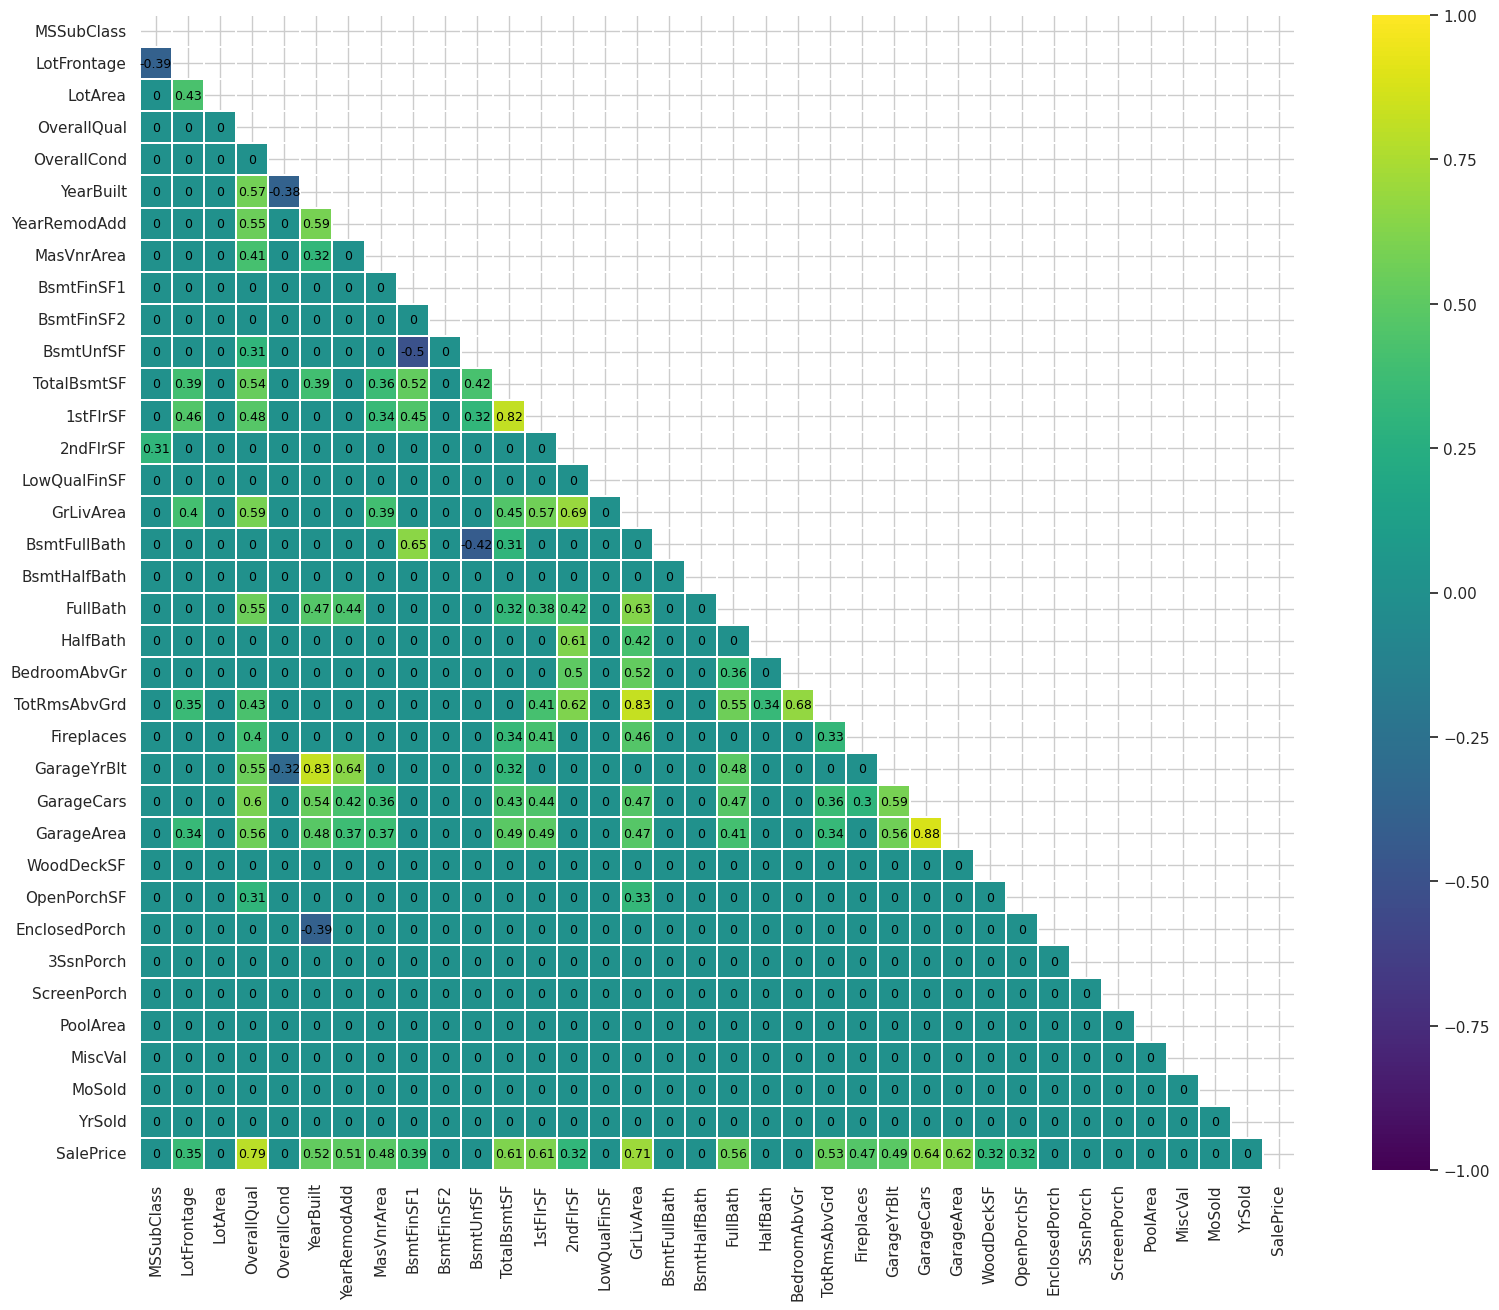

In [ ]:
# Choose the color map
cmap = "viridis"

# plot the heatmap
sns.heatmap(
    data = corr_matrix,
    mask = mask, # cover, not showing them which masked True
    vmax = 1.0,
    vmin = -1.0,
    linewidths = 0.1,
    annot_kws = {
        "size": 9,
        "color": "black"
    },
    square = True,
    cmap = cmap,
    annot = True
);

In [ ]:
# Let's select features where the correlation with 'SalePrice' is higher than |0.3|
# -1 because the latest row is SalePrice
df_num_corr = df_train_num.corr()["SalePrice"][:-1]

# Correlated features (r2 > 0.5)
high_features_list = df_num_corr[abs(df_num_corr) >= 0.5].sort_values(ascending=False)
print(f"{len(high_features_list)} strongly correlated values with SalePrice:\n{high_features_list}\n")

# Correlated features (0.3 < r2 < 0.5)
low_features_list = df_num_corr[(abs(df_num_corr) < 0.5) & (abs(df_num_corr) >= 0.3)].sort_values(ascending=False)
print(f"{len(low_features_list)} slightly correlated values with SalePrice:\n{low_features_list}")

10 strongly correlated values with SalePrice:
OverallQual    0.79
GrLivArea      0.71
GarageCars     0.64
GarageArea     0.62
TotalBsmtSF    0.61
1stFlrSF       0.61
FullBath       0.56
TotRmsAbvGrd   0.53
YearBuilt      0.52
YearRemodAdd   0.51
Name: SalePrice, dtype: float64

8 slightly correlated values with SalePrice:
GarageYrBlt   0.49
MasVnrArea    0.48
Fireplaces    0.47
BsmtFinSF1    0.39
LotFrontage   0.35
WoodDeckSF    0.32
2ndFlrSF      0.32
OpenPorchSF   0.32
Name: SalePrice, dtype: float64


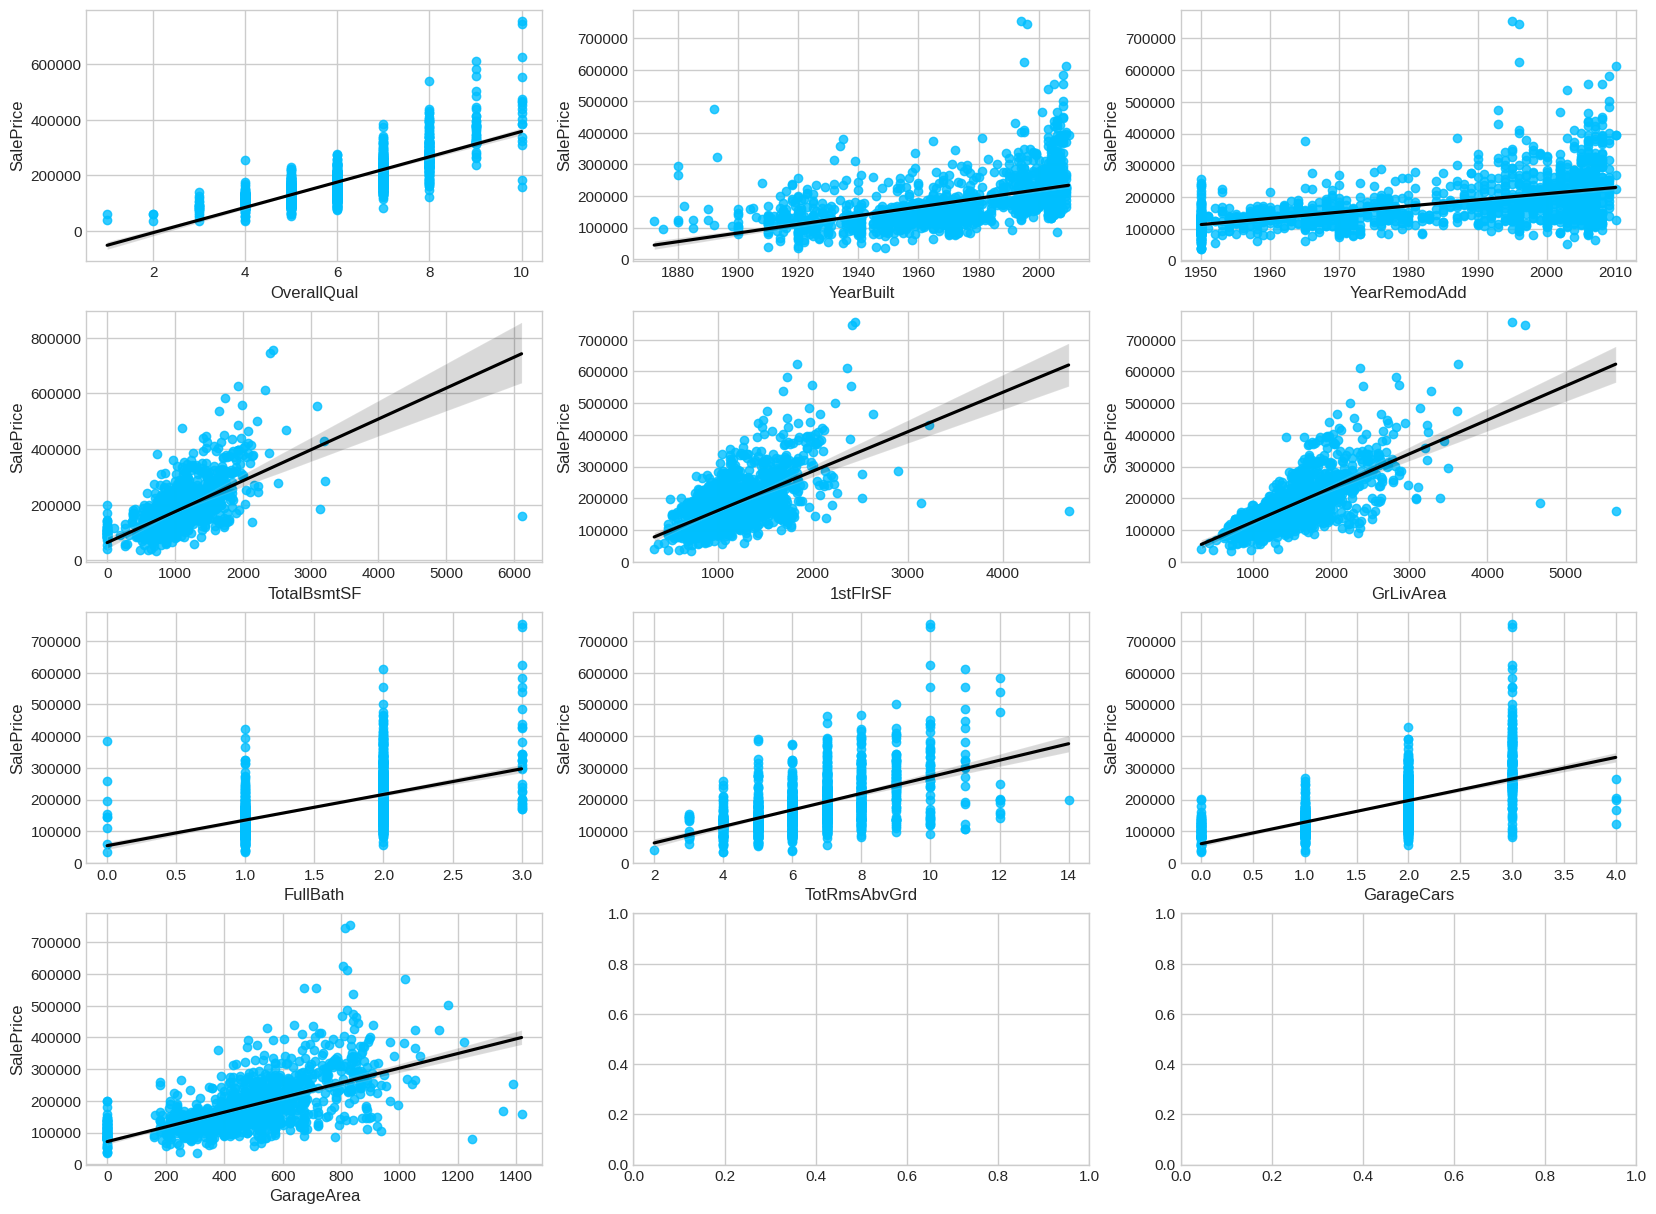

In [ ]:
# Features with high correlation (higher than 0.5)
strong_features = df_num_corr[abs(df_num_corr) >= 0.5].index.tolist()
strong_features.append("SalePrice")

df_strong_features = df_train_num.loc[:, strong_features]

plt.style.use("seaborn-whitegrid")  # define figures style
fig, ax = plt.subplots(round(len(strong_features) / 3), 3)

for i, ax in enumerate(fig.axes):
    # plot the correlation of each feature with SalePrice
    if i < len(strong_features)-1:
        sns.regplot(
            x=strong_features[i],
            y="SalePrice",
            data=df_strong_features,
            ax=ax,
            scatter_kws= {"color": "deepskyblue"},
            line_kws={"color": "black"}
        )

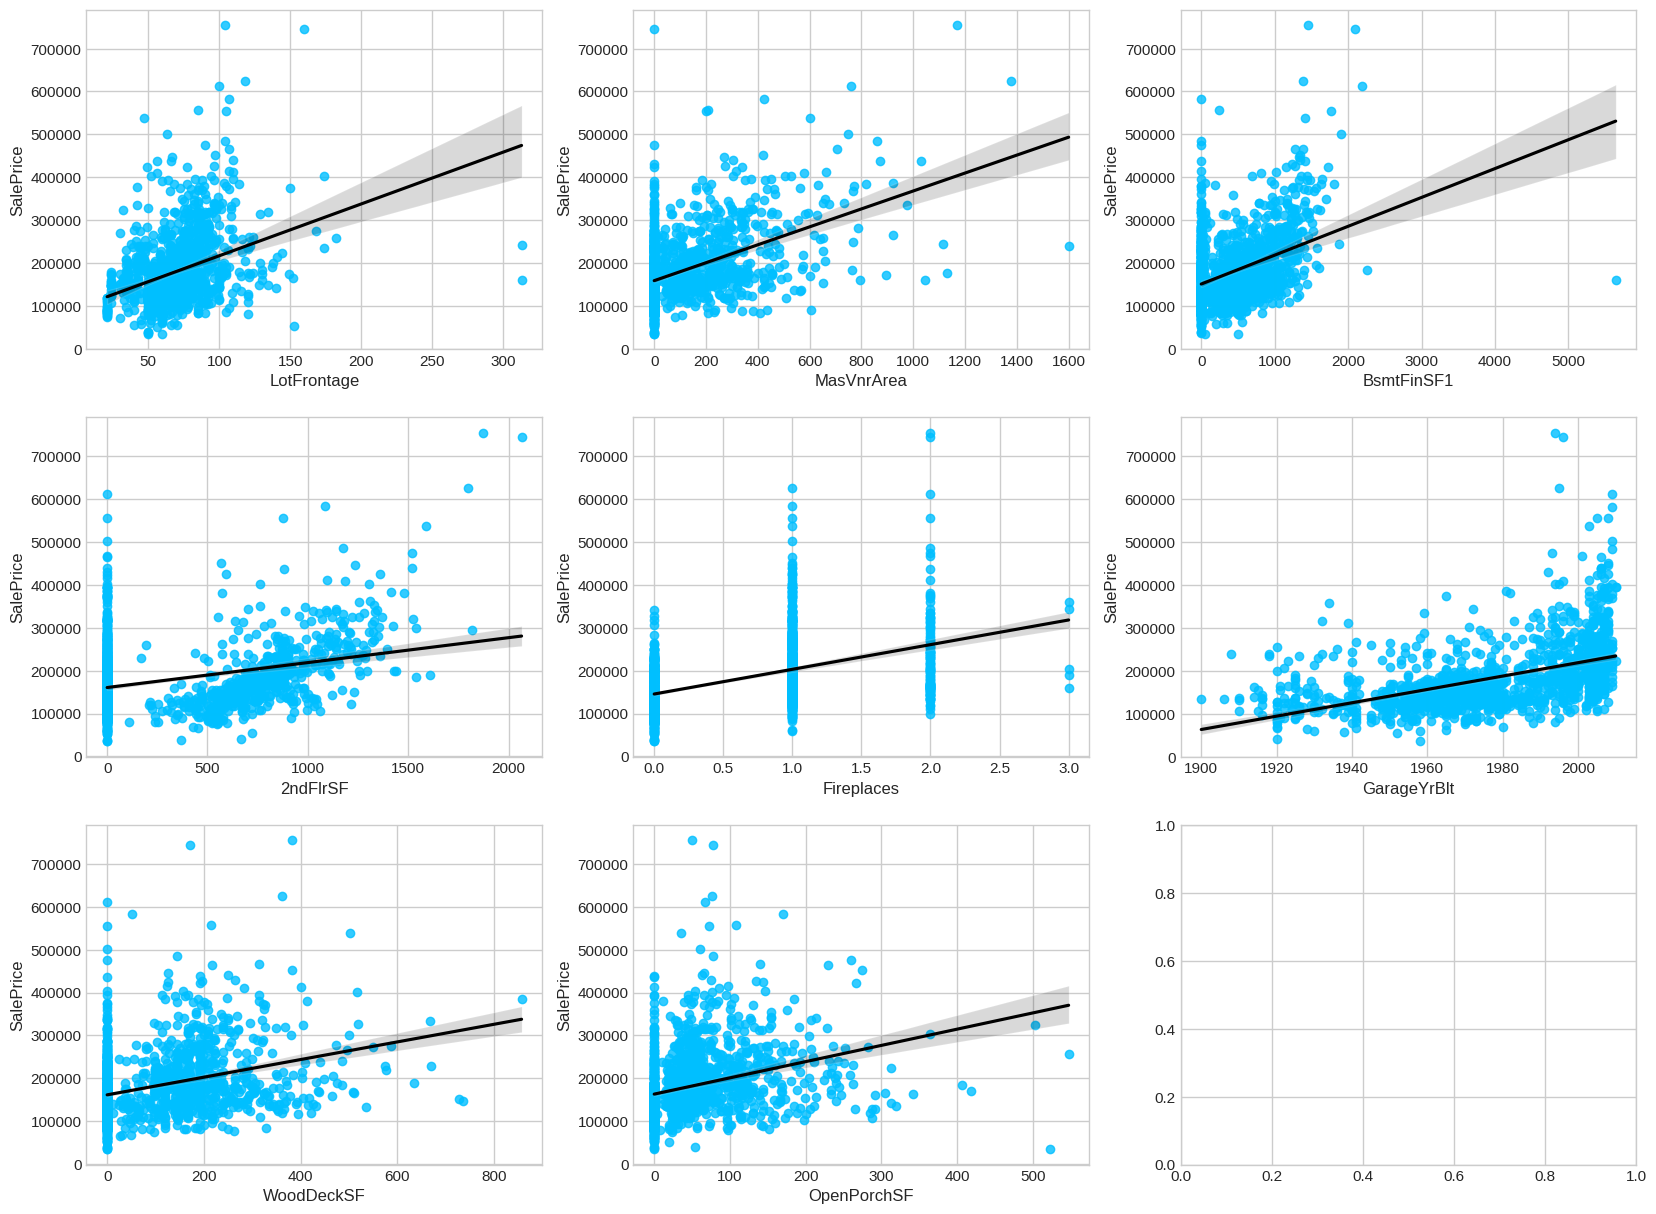

In [ ]:
# Features with low correlation (between 0.3 and 0.5)
low_features = df_num_corr[(abs(df_num_corr) >= 0.3) & (abs(df_num_corr) < 0.5)].index.tolist()
low_features.append("SalePrice")

df_low_features = df_train_num.loc[:, low_features]

plt.style.use("seaborn-whitegrid")  # define figures style
fig, ax = plt.subplots(round(len(low_features) / 3), 3)

for i, ax in enumerate(fig.axes):
    # plot the correlation of each feature with SalePrice
    if i < len(low_features) - 1:
        sns.regplot(
            x=low_features[i],
            y="SalePrice",
            data=df_low_features,
            ax=ax,
            scatter_kws={"color": "deepskyblue"},
            line_kws={"color": "black"}
        )

In [ ]:
# Define the list of numerical fetaures to keep
list_of_numerical_features = strong_features[:-1] + low_features

# Let's select these features form our train set
df_train_num = df_train_num.loc[:, list_of_numerical_features]

# The same features are selected from the test set (-1 -> except 'SalePrice')
df_test_num = df_test.loc[:, list_of_numerical_features[:-1]]

In [ ]:
df_strong_features

In [ ]:
list_of_numerical_features

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'GarageArea',
 'LotFrontage',
 'MasVnrArea',
 'BsmtFinSF1',
 '2ndFlrSF',
 'Fireplaces',
 'GarageYrBlt',
 'WoodDeckSF',
 'OpenPorchSF',
 'SalePrice']

## I.2.2 Missing data of Numerical features

Train Set

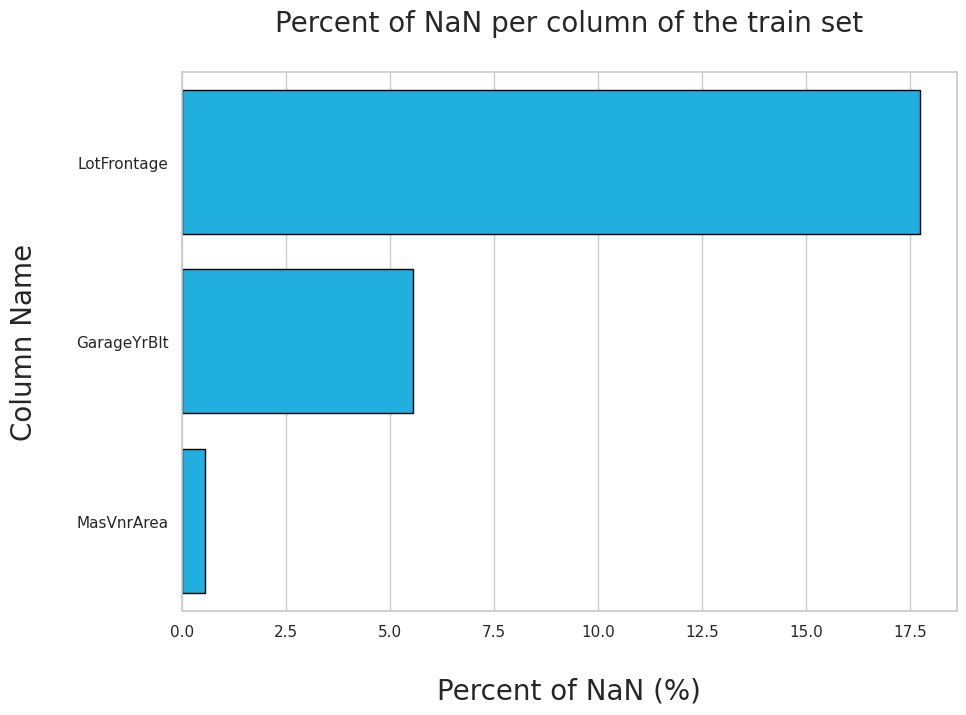

In [ ]:
# Check the NaN of the train set by ploting percent of missing values per column
column_with_nan = df_train_num.columns[df_train_num.isnull().any()]
column_name = []
percent_nan = []

for i in column_with_nan:
    column_name.append(i)
    percent_nan.append(round(df_train_num[i].isnull().sum()*100/len(df_train_num), 2))

tab = pd.DataFrame(column_name, columns=["Column"])
tab["Percent_NaN"] = percent_nan
tab.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)


# Define figure parameters
sns.set(rc={"figure.figsize": (10, 7)})
sns.set_style("whitegrid")

# Plot results
p = sns.barplot(x="Percent_NaN", y="Column", data=tab,
                edgecolor="black", color="deepskyblue")

p.set_title("Percent of NaN per column of the train set\n", fontsize=20)
p.set_xlabel("\nPercent of NaN (%)", fontsize=20)
p.set_ylabel("Column Name\n", fontsize=20);

In [ ]:
# Imputation of missing values (NaNs) with SimpleImputer
my_imputer = SimpleImputer(strategy="median")
df_train_imputed = pd.DataFrame(my_imputer.fit_transform(df_train_num))
df_train_imputed.head()

0        1        2        3        4        5    6    7    8      9   \
0 7.00 2,003.00 2,003.00   856.00   856.00 1,710.00 2.00 8.00 2.00 548.00   
1 6.00 1,976.00 1,976.00 1,262.00 1,262.00 1,262.00 2.00 6.00 2.00 460.00   
2 7.00 2,001.00 2,002.00   920.00   920.00 1,786.00 2.00 6.00 2.00 608.00   
3 7.00 1,915.00 1,970.00   756.00   961.00 1,717.00 1.00 7.00 3.00 642.00   
4 8.00 2,000.00 2,000.00 1,145.00 1,145.00 2,198.00 2.00 9.00 3.00 836.00   

     10     11     12       13   14       15     16    17         18  
0 65.00 196.00 706.00   854.00 0.00 2,003.00   0.00 61.00 208,500.00  
1 80.00   0.00 978.00     0.00 1.00 1,976.00 298.00  0.00 181,500.00  
2 68.00 162.00 486.00   866.00 1.00 2,001.00   0.00 42.00 223,500.00  
3 60.00   0.00 216.00   756.00 1.00 1,998.00   0.00 35.00 140,000.00  
4 84.00 350.00 655.00 1,053.00 1.00 2,000.00 192.00 84.00 250,000.00

In [ ]:
df_train_imputed.columns = df_train_num.columns
df_train_imputed.head()

OverallQual  YearBuilt  YearRemodAdd  TotalBsmtSF  1stFlrSF  GrLivArea  \
0         7.00   2,003.00      2,003.00       856.00    856.00   1,710.00   
1         6.00   1,976.00      1,976.00     1,262.00  1,262.00   1,262.00   
2         7.00   2,001.00      2,002.00       920.00    920.00   1,786.00   
3         7.00   1,915.00      1,970.00       756.00    961.00   1,717.00   
4         8.00   2,000.00      2,000.00     1,145.00  1,145.00   2,198.00   

   FullBath  TotRmsAbvGrd  GarageCars  GarageArea  LotFrontage  MasVnrArea  \
0      2.00          8.00        2.00      548.00        65.00      196.00   
1      2.00          6.00        2.00      460.00        80.00        0.00   
2      2.00          6.00        2.00      608.00        68.00      162.00   
3      1.00          7.00        3.00      642.00        60.00        0.00   
4      2.00          9.00        3.00      836.00        84.00      350.00   

   BsmtFinSF1  2ndFlrSF  Fireplaces  GarageYrBlt  WoodDeckSF  OpenPorchSF  \
0      706.00    854.00        0.00     2,003.00        0.00        61.00   
1      978.00      0.00        1.00     1,976.00      298.00         0.00   
2      486.00    866.00        1.00     2,001.00        0.00        42.00   
3      216.00    756.00        1.00     1,998.00        0.00        35.00   
4      655.00  1,053.00        1.00     2,000.00      192.00        84.00   

   SalePrice  
0 208,500.00  
1 181,500.00  
2 223,500.00  
3 140,000.00  
4 250,000.00

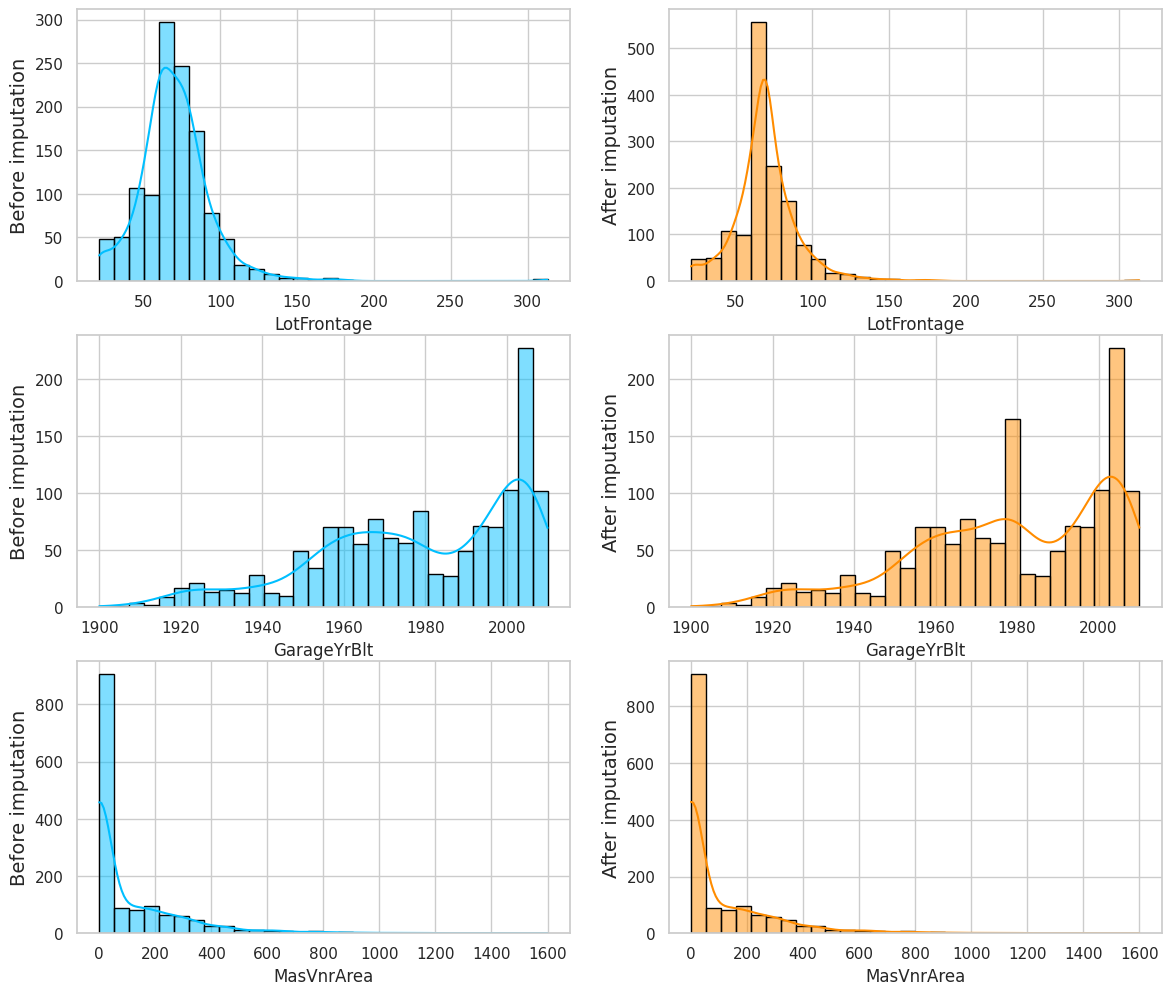

In [ ]:
# Let's check the distribution of each imputed feature before and after imputation

# Define figure parameters
sns.set(rc={"figure.figsize": (14, 12)})
sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 2)

# Plot the results
for feature, fig_pos in zip(["LotFrontage", "GarageYrBlt", "MasVnrArea"], [0, 1, 2]):

    """Features distribution before and after imputation"""

    # before imputation
    p = sns.histplot(ax=axes[fig_pos, 0], x=df_train_num[feature],
                     kde=True, bins=30, color="deepskyblue", edgecolor="black")
    p.set_ylabel(f"Before imputation", fontsize=14)

    # after imputation
    q = sns.histplot(ax=axes[fig_pos, 1], x=df_train_imputed[feature],
                     kde=True, bins=30, color="darkorange", edgecolor="black")
    q.set_ylabel(f"After imputation", fontsize=14)

In [ ]:
# Drop 'LotFrontage' and 'GarageYrBlt'
df_train_imputed.drop(["LotFrontage", "GarageYrBlt"], axis=1, inplace=True)
df_train_imputed.head()

OverallQual  YearBuilt  YearRemodAdd  TotalBsmtSF  1stFlrSF  GrLivArea  \
0         7.00   2,003.00      2,003.00       856.00    856.00   1,710.00   
1         6.00   1,976.00      1,976.00     1,262.00  1,262.00   1,262.00   
2         7.00   2,001.00      2,002.00       920.00    920.00   1,786.00   
3         7.00   1,915.00      1,970.00       756.00    961.00   1,717.00   
4         8.00   2,000.00      2,000.00     1,145.00  1,145.00   2,198.00   

   FullBath  TotRmsAbvGrd  GarageCars  GarageArea  MasVnrArea  BsmtFinSF1  \
0      2.00          8.00        2.00      548.00      196.00      706.00   
1      2.00          6.00        2.00      460.00        0.00      978.00   
2      2.00          6.00        2.00      608.00      162.00      486.00   
3      1.00          7.00        3.00      642.00        0.00      216.00   
4      2.00          9.00        3.00      836.00      350.00      655.00   

   2ndFlrSF  Fireplaces  WoodDeckSF  OpenPorchSF  SalePrice  
0    854.00        0.00        0.00        61.00 208,500.00  
1      0.00        1.00      298.00         0.00 181,500.00  
2    866.00        1.00        0.00        42.00 223,500.00  
3    756.00        1.00        0.00        35.00 140,000.00  
4  1,053.00        1.00      192.00        84.00 250,000.00

Test Set

In [ ]:
# Drop the same features from test set as for the train set
df_test_num.drop(["LotFrontage", "GarageYrBlt"], axis=1, inplace=True)

Text(0, 0.5, 'Column Name\n')

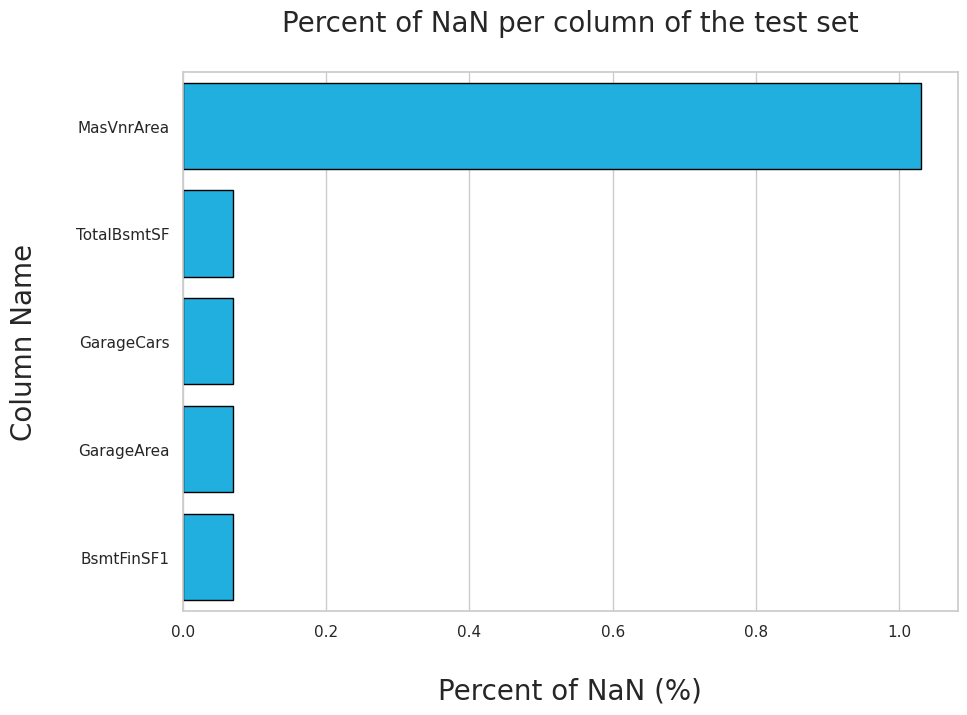

In [ ]:
# Check the NaN of the test set by ploting percent of missing values per column
column_with_nan = df_test_num.columns[df_test_num.isnull().any()]
column_name = []
percent_nan = []

for i in column_with_nan:
    column_name.append(i)
    percent_nan.append(
        round(df_test_num[i].isnull().sum()*100/len(df_test_num), 2))

tab = pd.DataFrame(column_name, columns=["Column"])
tab["Percent_NaN"] = percent_nan
tab.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)


# Define figure parameters
sns.set(rc={"figure.figsize": (10, 7)})
sns.set_style("whitegrid")

# Plot results
p = sns.barplot(x="Percent_NaN", y="Column", data=tab,
                edgecolor="black", color="deepskyblue")

p.set_title("Percent of NaN per column of the test set\n", fontsize=20)
p.set_xlabel("\nPercent of NaN (%)", fontsize=20)
p.set_ylabel("Column Name\n", fontsize=20)

In [ ]:
# Imputation of missing values (NaNs) with SimpleImputer
my_imputer = SimpleImputer(strategy="median")
df_test_imputed = pd.DataFrame(my_imputer.fit_transform(df_test_num))
df_test_imputed.columns = df_test_num.columns

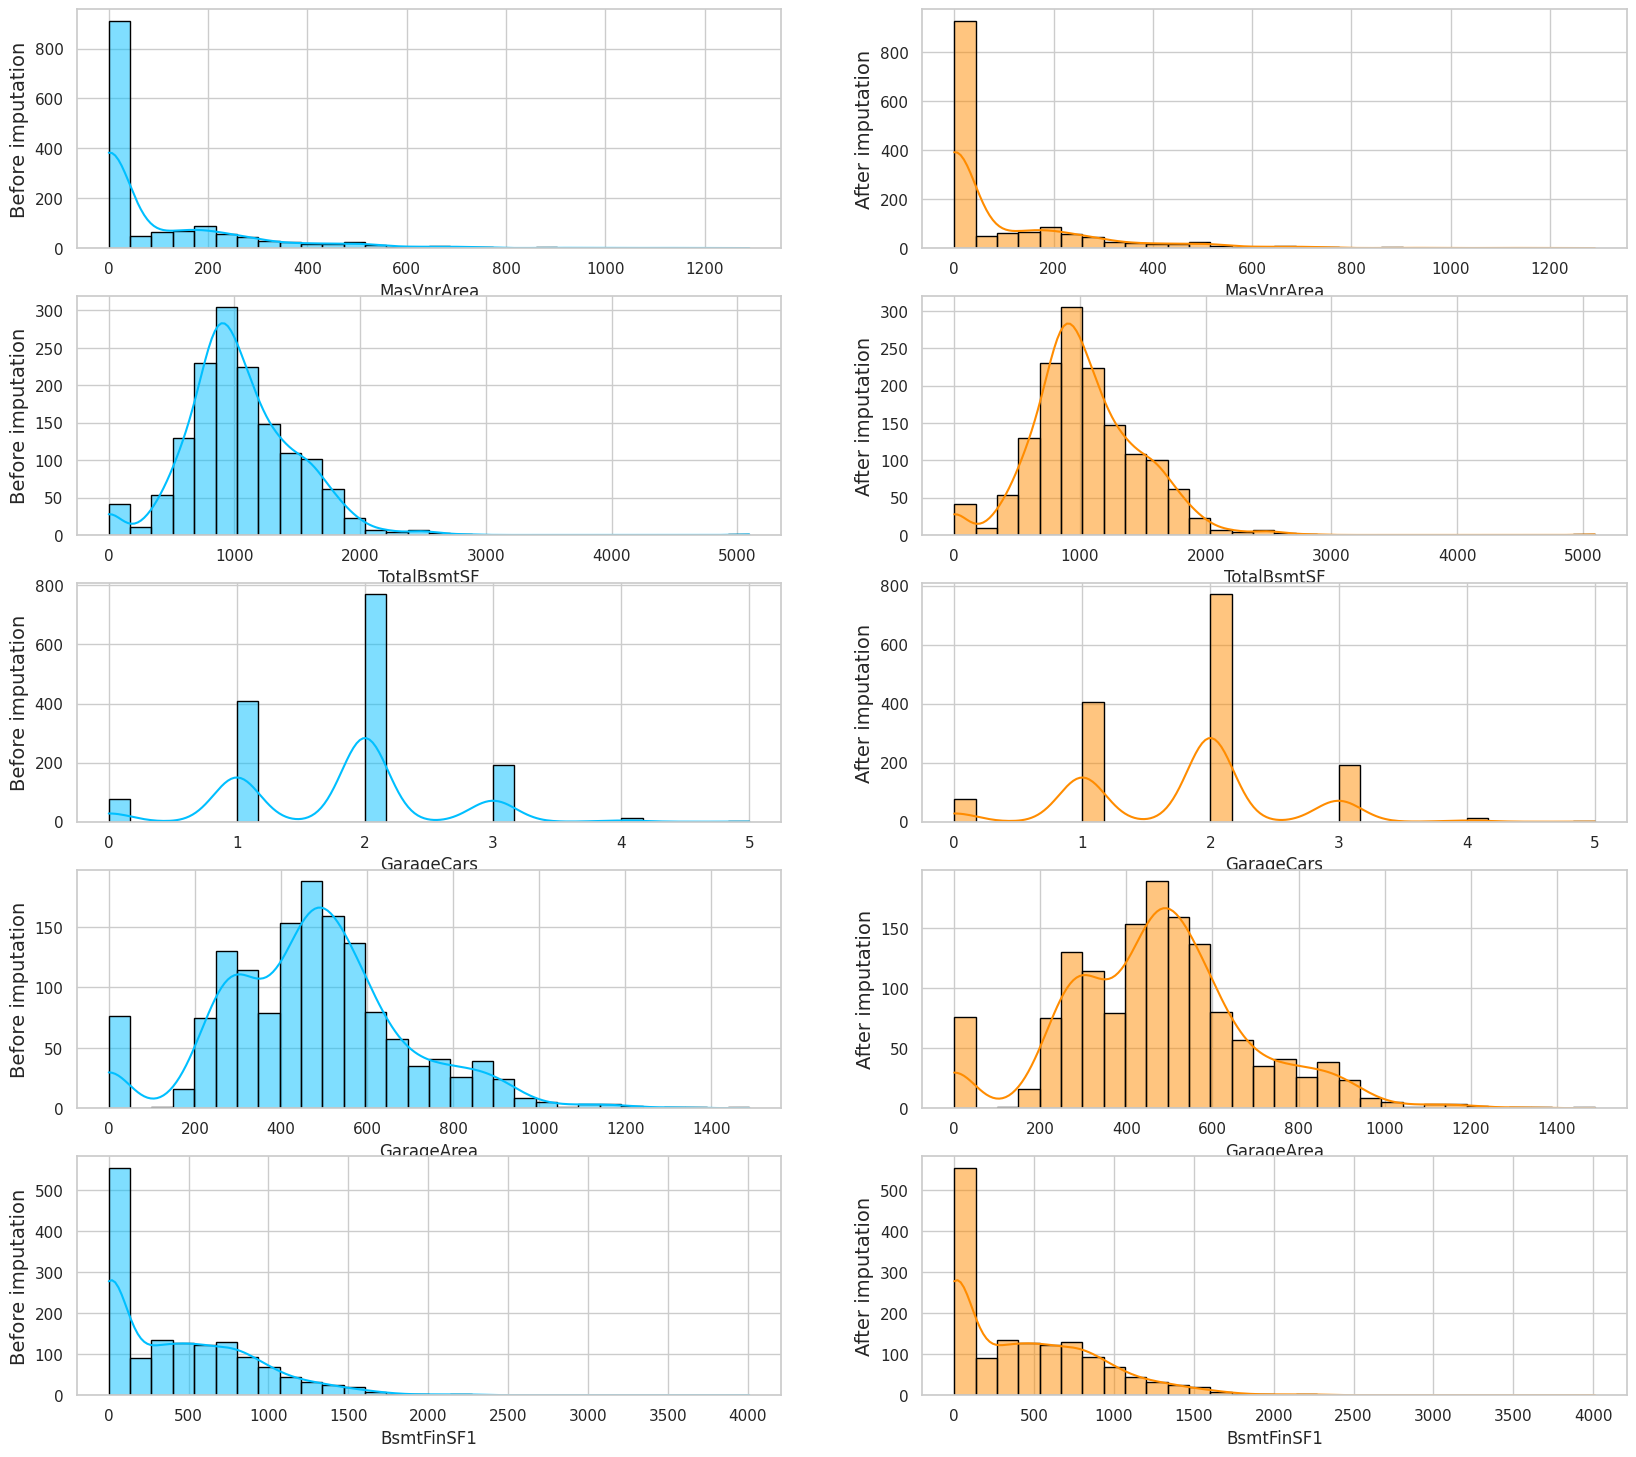

In [ ]:
# Let's check the distribution of each imputed feature before and after imputation

# Define figure parameters
sns.set(rc={"figure.figsize": (20, 18)})
sns.set_style("whitegrid")
fig, axes = plt.subplots(5, 2)

# Plot the results
for feature, fig_pos in zip(tab["Column"].tolist(), range(0, 6)):

    """Features distribution before and after imputation"""

    # before imputation
    p = sns.histplot(ax=axes[fig_pos, 0], x=df_test_num[feature],
                     kde=True, bins=30, color="deepskyblue", edgecolor="black")
    p.set_ylabel(f"Before imputation", fontsize=14)

    # after imputation
    q = sns.histplot(ax=axes[fig_pos, 1], x=df_test_imputed[feature],
                     kde=True, bins=30, color="darkorange", edgecolor="black",)
    q.set_ylabel(f"After imputation", fontsize=14)

# I.3 Categorical features

## I.3.1. Explore and clean Categorical features

In [ ]:
# Categorical to Quantitative relationship

# categorical_features = [i for i in df_train.columns if df_train.dtypes[i] == "object"] # -->list comprehension

# for-loop
categorical_features = []
for feat, feat_type in zip(df_train.columns, df_train.dtypes):
    if feat_type == 'object':
       categorical_features.append(feat)

# Include target variable
categorical_features.append("SalePrice")

# Train set
df_train_categ = df_train[categorical_features]

# Test set (-1 because test set don't have 'Sale Price')
df_test_categ = df_test[categorical_features[:-1]]

df_test_categ.head()

MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
0       RH   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1       RL   Pave   NaN      IR1         Lvl    AllPub    Corner       Gtl   
2       RL   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl   
3       RL   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl   
4       RL   Pave   NaN      IR1         HLS    AllPub    Inside       Gtl   

  Neighborhood Condition1  ... GarageType GarageFinish GarageQual GarageCond  \
0        NAmes      Feedr  ...     Attchd          Unf         TA         TA   
1        NAmes       Norm  ...     Attchd          Unf         TA         TA   
2      Gilbert       Norm  ...     Attchd          Fin         TA         TA   
3      Gilbert       Norm  ...     Attchd          Fin         TA         TA   
4      StoneBr       Norm  ...     Attchd          RFn         TA         TA   

  PavedDrive PoolQC  Fence MiscFeature SaleType SaleCondition  
0          Y    NaN  MnPrv         NaN       WD        Normal  
1          Y    NaN    NaN        Gar2       WD        Normal  
2          Y    NaN  MnPrv         NaN       WD        Normal  
3          Y    NaN    NaN         NaN       WD        Normal  
4          Y    NaN    NaN         NaN       WD        Normal  

[5 rows x 43 columns]

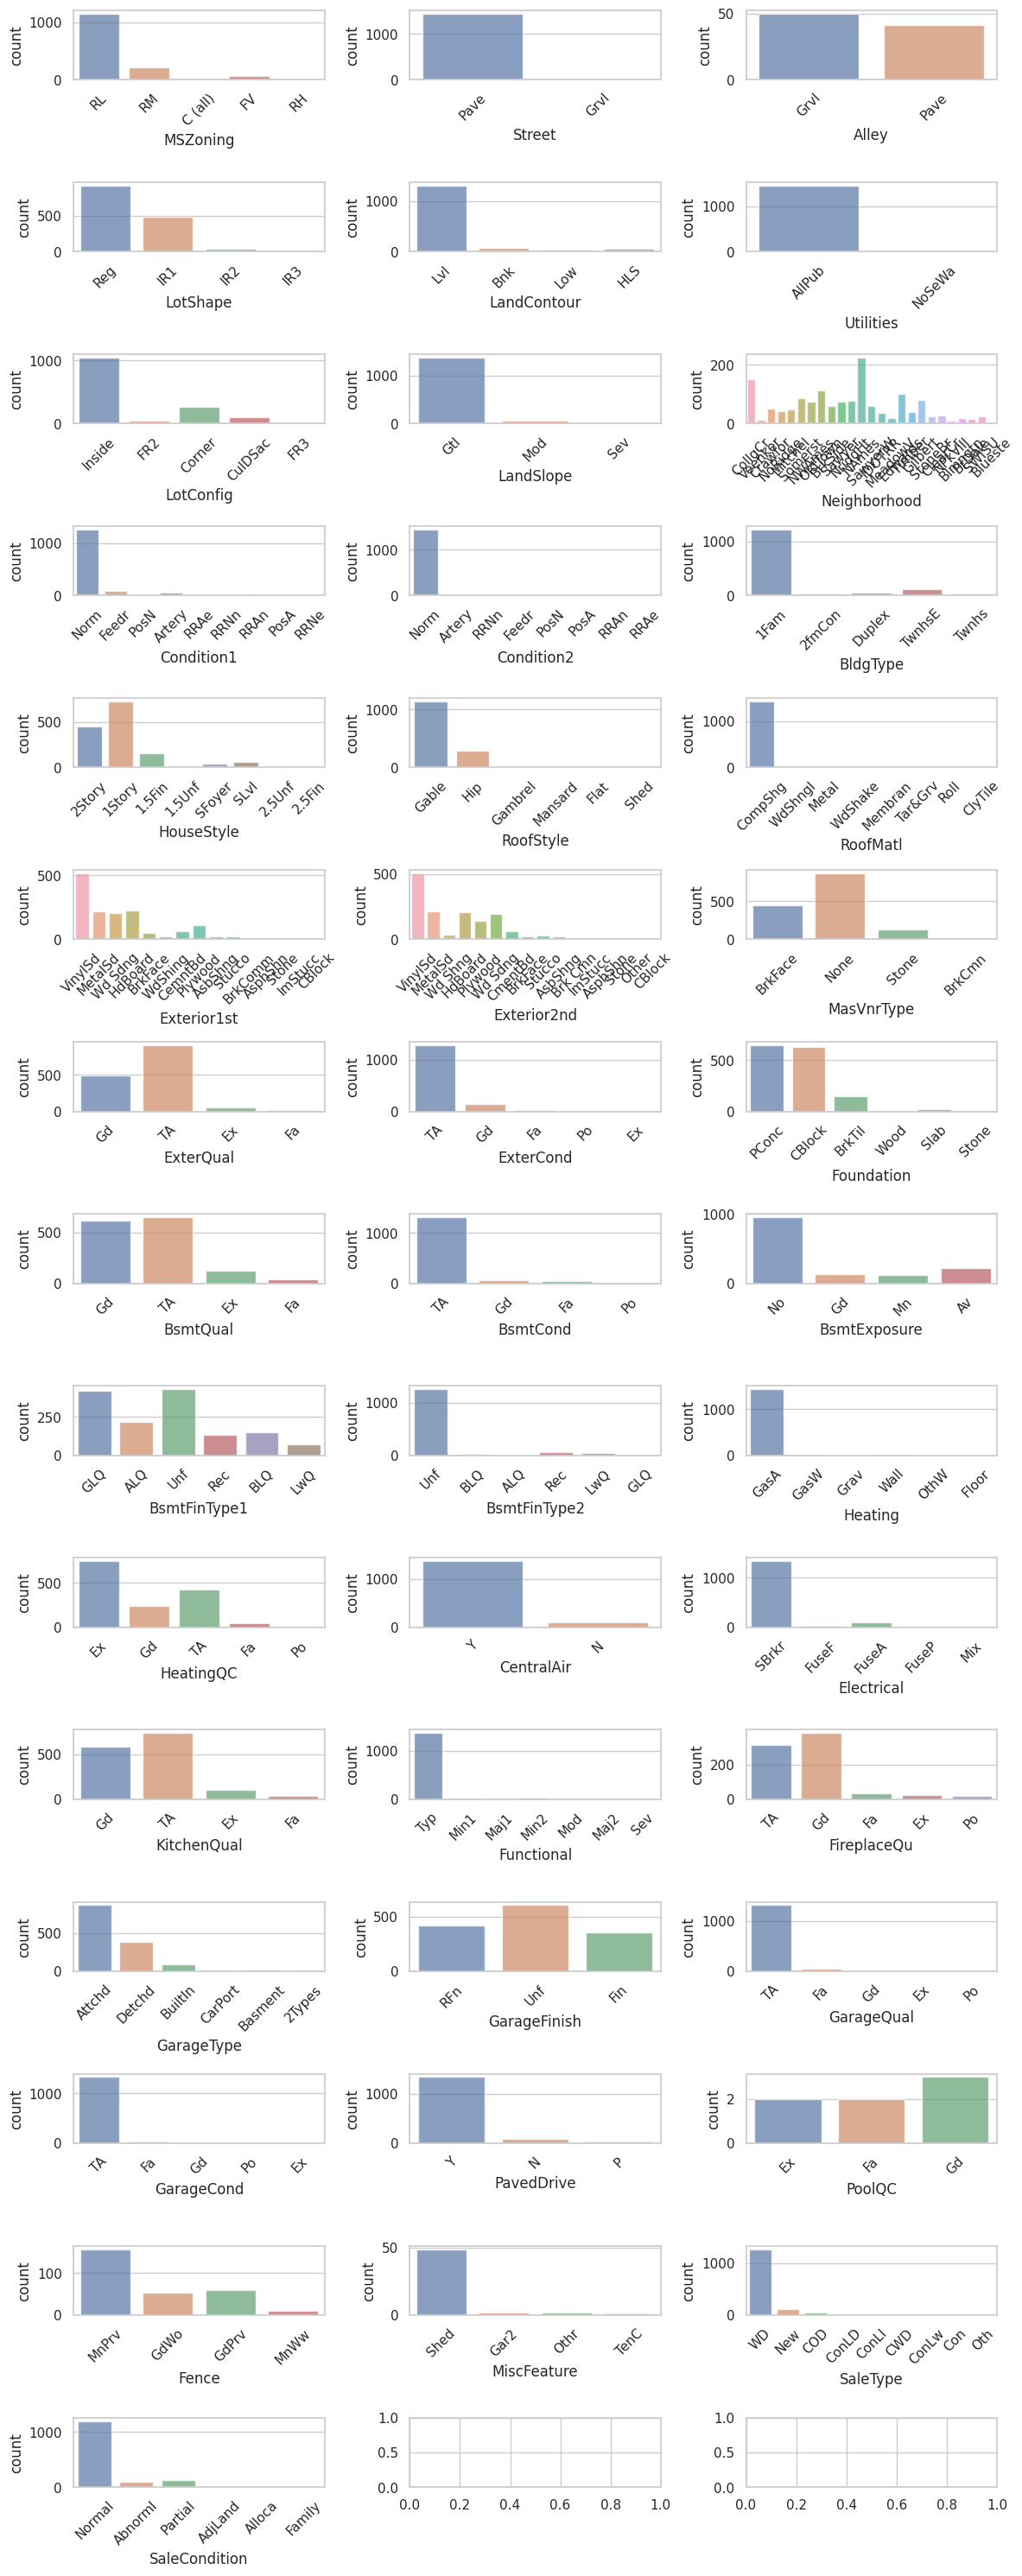

In [ ]:
# Countplot for each of the categorical features in the train set
fig, axes = plt.subplots(
    round(len(df_train_categ.columns) / 3), 3, figsize=(12, 30))

for i, ax in enumerate(fig.axes):
    # plot barplot of each feature
    if i < len(df_train_categ.columns) - 1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(
            x=df_train_categ.columns[i], alpha=0.7, data=df_train_categ, ax=ax)

fig.tight_layout()

In [ ]:
# Drop some categorical 'non-informative' features from train set
columns_to_drop = ['Street', 'Alley', 'LandContour', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl',
                   'CentralAir', 'BsmtFinType2', 'Heating', 'Functional','GarageQual', 'GarageCond',
                   'ExterCond','MiscFeature', 'PavedDrive', 'SaleType']

In [ ]:
# Train set
df_train_categ.drop(columns_to_drop, axis=1, inplace=True)

# Test set
df_test_categ.drop(columns_to_drop, axis=1, inplace=True)

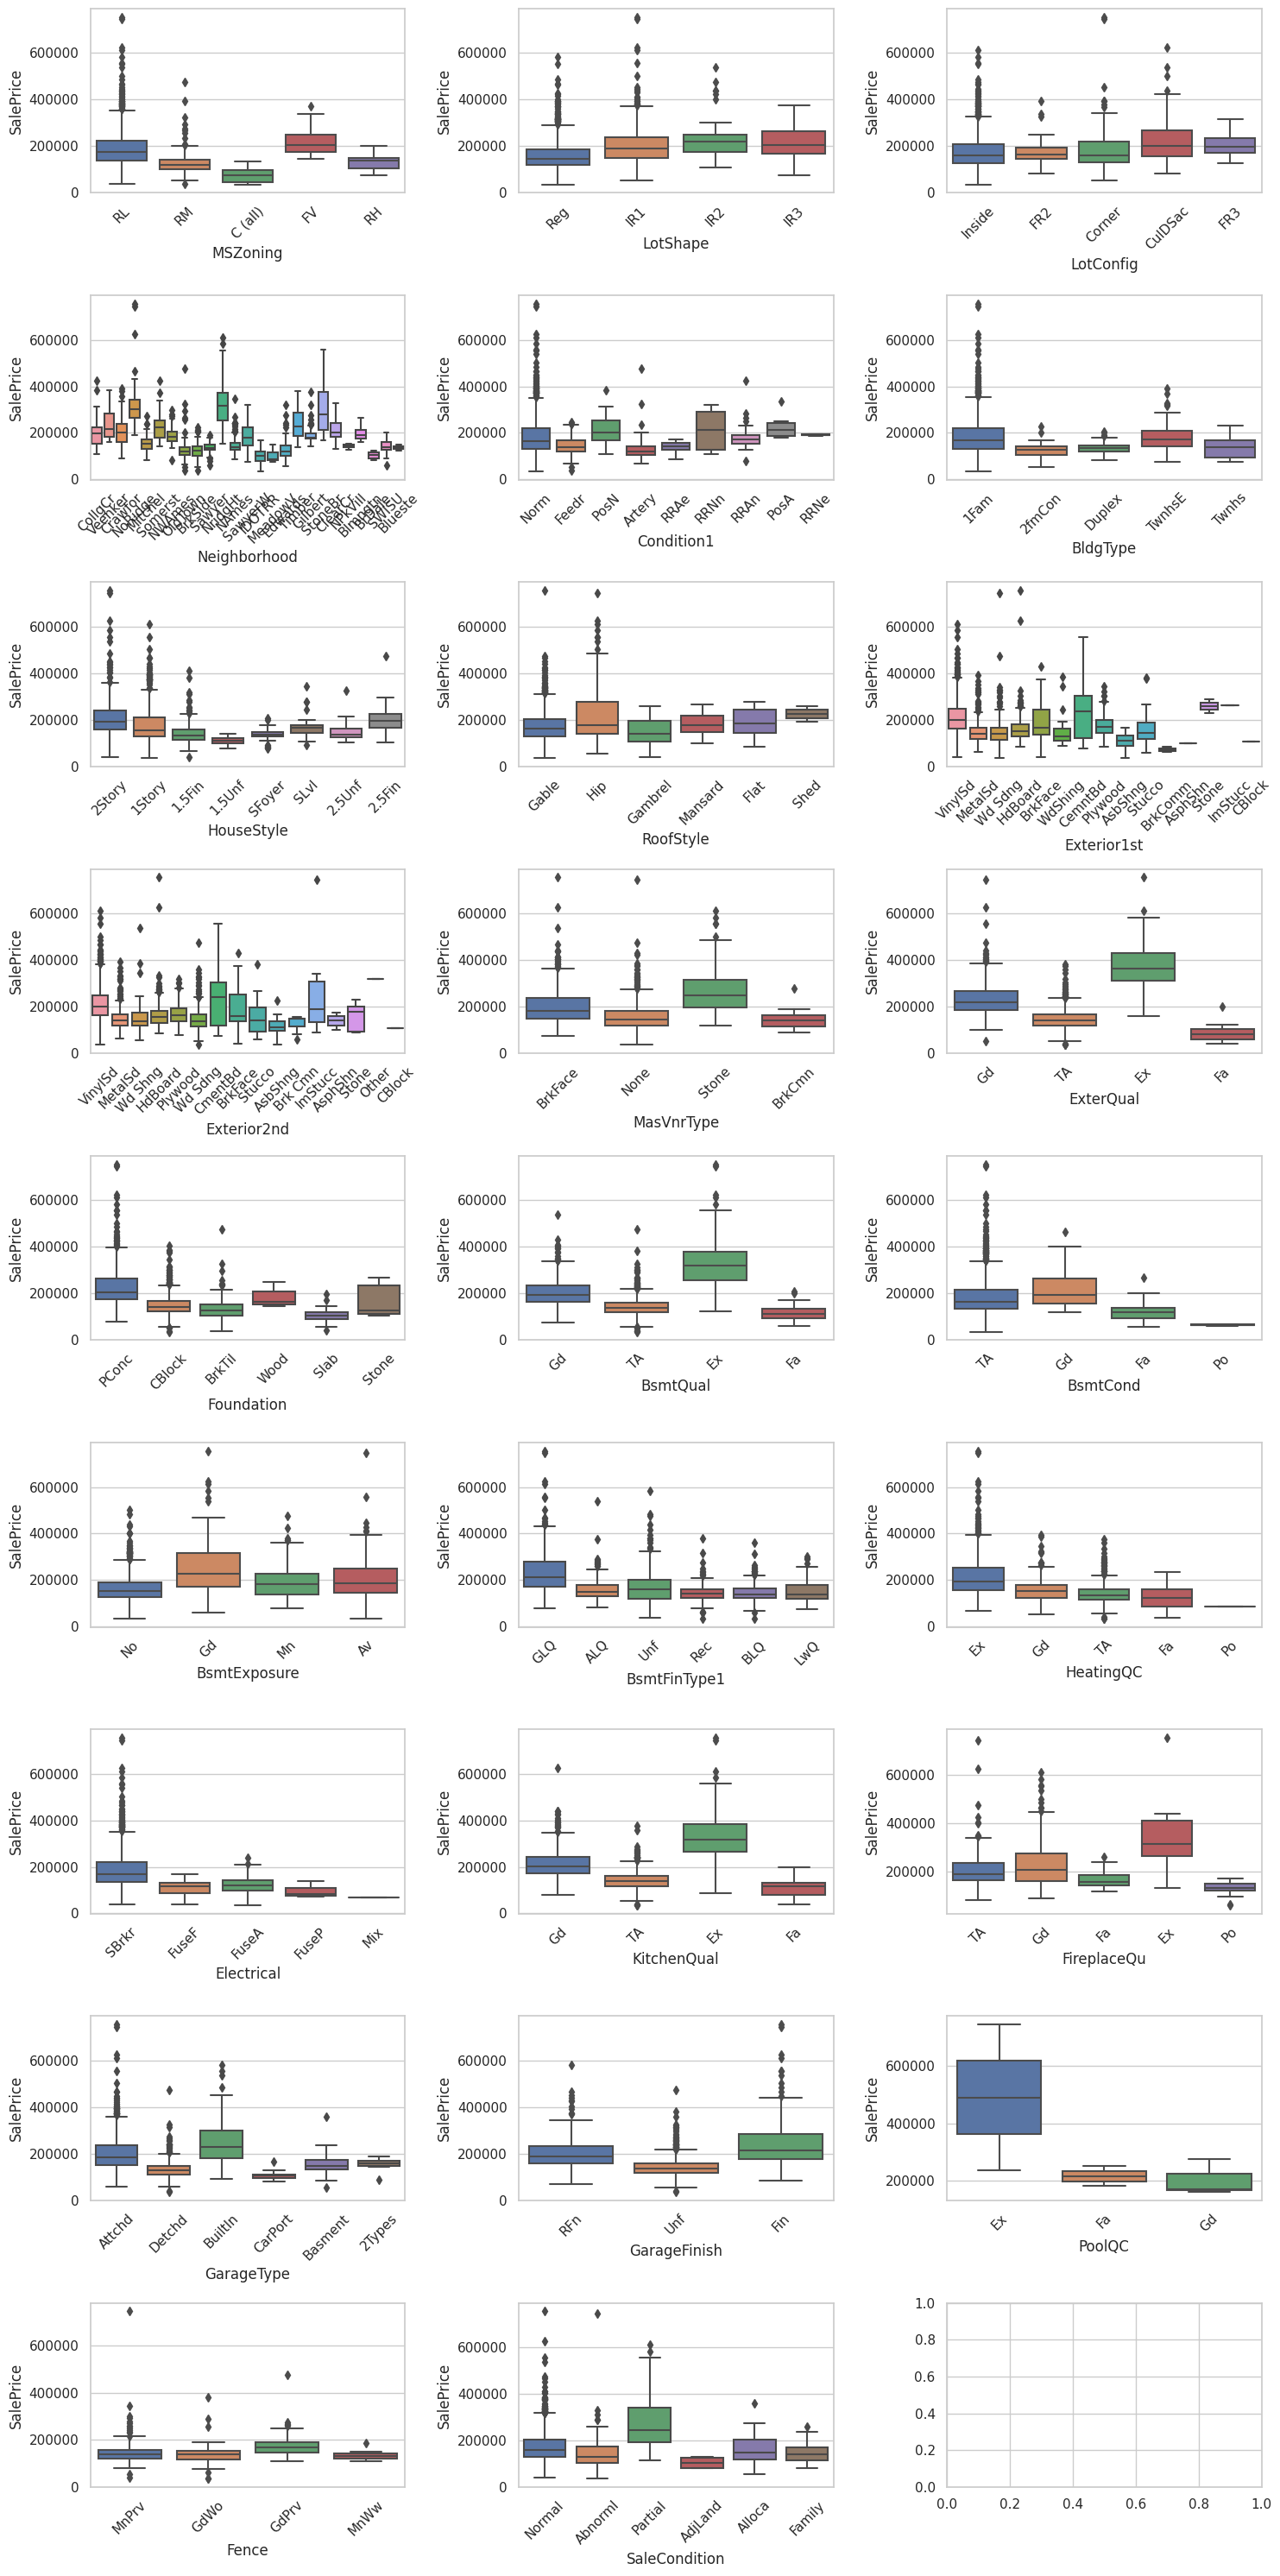

In [ ]:
# With the boxplot we can see the variation of the target 'SalePrice' in each of the categorical features
fig, axes = plt.subplots(
    round(len(df_train_categ.columns)/3), 3, figsize=(15, 30))

for i, ax in enumerate(fig.axes):
    # plot the variation of SalePrice in each feature
    if i < len(df_train_categ.columns) - 1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.boxplot(
            x=df_train_categ.columns[i], y="SalePrice", data=df_train_categ, ax=ax)

fig.tight_layout()

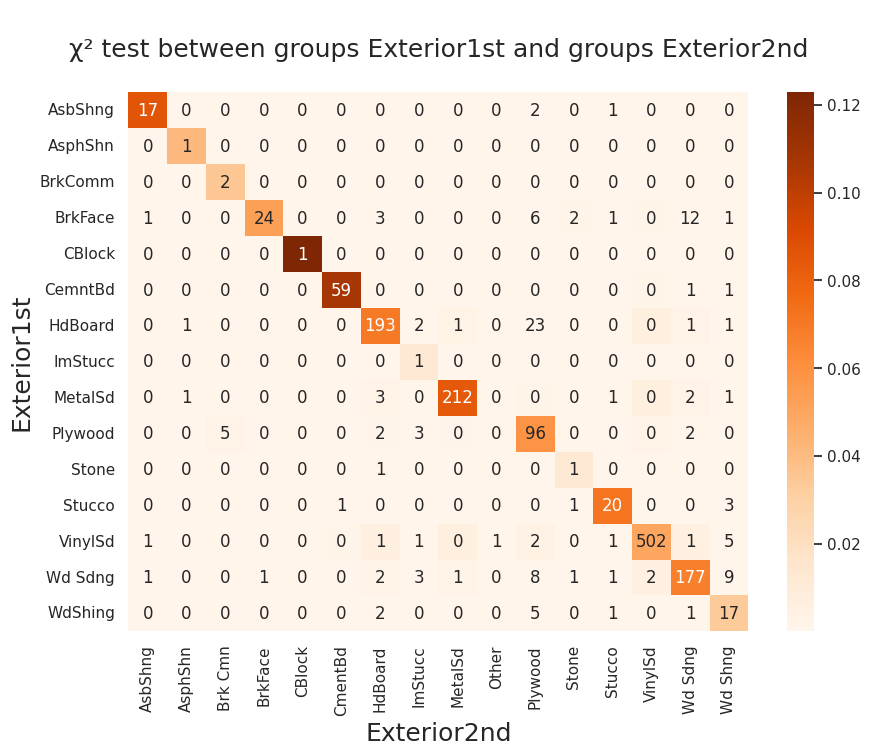

P-Value of the ChiSq Test bewteen Exterior1st and Exterior2nd is: 0.0



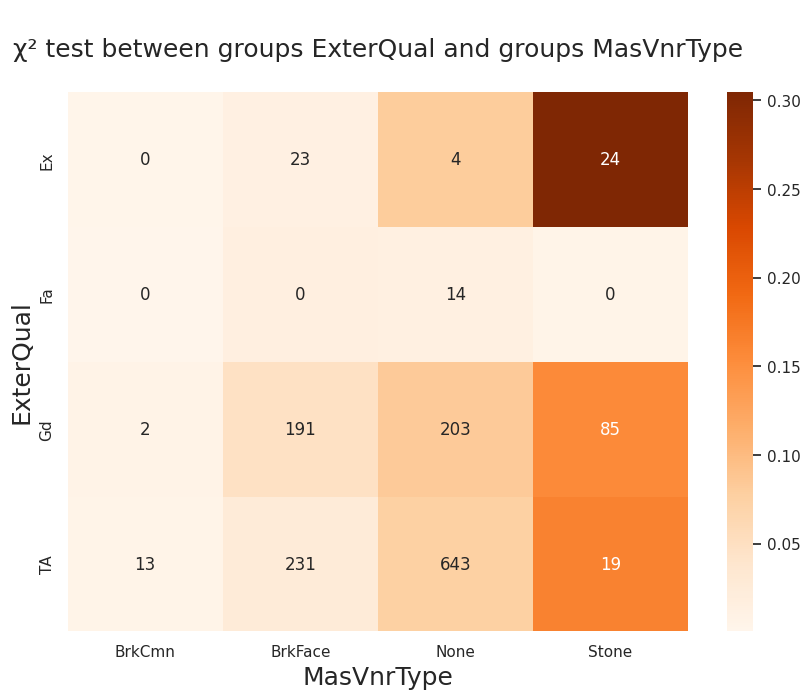

P-Value of the ChiSq Test bewteen ExterQual and MasVnrType is: 1.0187554679218715e-54



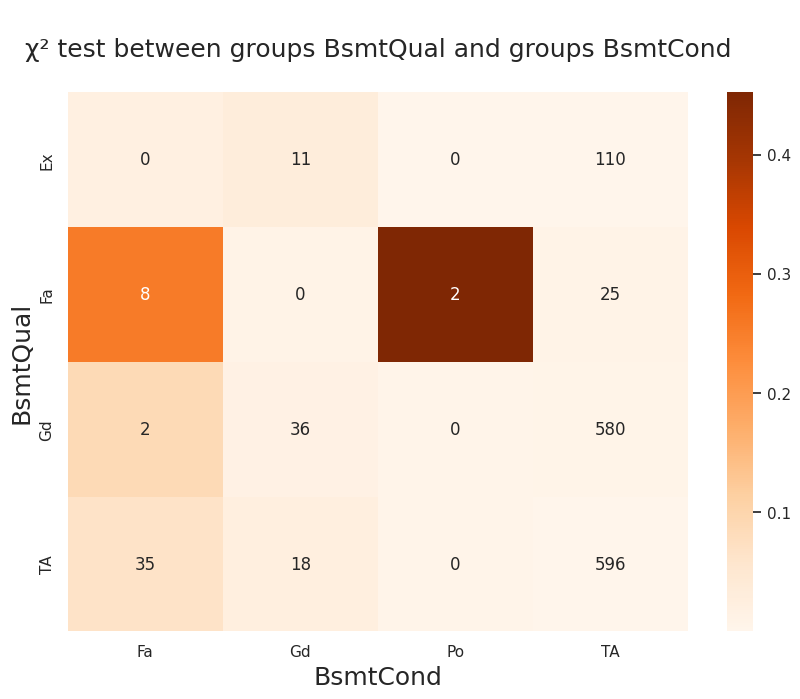

P-Value of the ChiSq Test bewteen BsmtQual and BsmtCond is: 1.9371809126533347e-31



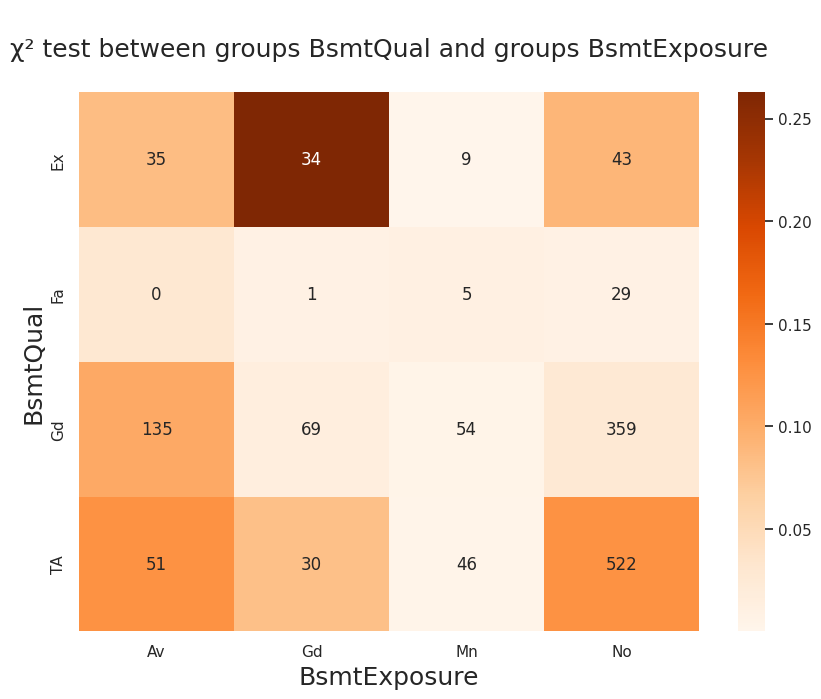

P-Value of the ChiSq Test bewteen BsmtQual and BsmtExposure is: 3.879215036512606e-32



In [ ]:
# Plot contingency table

sns.set(rc={"figure.figsize": (10, 7)})

X = ["Exterior1st", "ExterQual", "BsmtQual", "BsmtQual", "BsmtQual"]
Y = ["Exterior2nd", "MasVnrType", "BsmtCond", "BsmtExposure"]

for i, j in zip(X, Y):

    # Contingency table
    cont = df_train_categ[[i, j]].pivot_table(
        index=i, columns=j, aggfunc=len, margins=True, margins_name="Total")
    tx = cont.loc[:, ["Total"]]
    ty = cont.loc[["Total"], :]
    n = len(df_train_categ)
    indep = tx.dot(ty) / n
    c = cont.fillna(0)  # Replace NaN with 0 in the contingency table
    measure = (c - indep) ** 2 / indep
    xi_n = measure.sum().sum()
    table = measure / xi_n

    # Plot contingency table
    p = sns.heatmap(table.iloc[:-1, :-1],
                    annot=c.iloc[:-1, :-1], fmt=".0f", cmap="Oranges")
    p.set_xlabel(j, fontsize=18)
    p.set_ylabel(i, fontsize=18)
    p.set_title(f"\nχ² test between groups {i} and groups {j}\n", size=18)
    plt.show()

    # Performing Chi-sq test
    CrosstabResult = pd.crosstab(
        index=df_train_categ[i], columns=df_train_categ[j])
    ChiSqResult = chi2_contingency(CrosstabResult)
    # P-Value is the Probability of H0 being True
    print(
        f"P-Value of the ChiSq Test bewteen {i} and {j} is: {ChiSqResult[1]}\n")

In [ ]:
# Let's drop the one of each co-dependent variables
# Train set
df_train_categ.drop(Y, axis=1, inplace=True)

# Test set
df_test_categ.drop(Y, axis=1, inplace=True)

## I.3.2 Missing data of Categorical features

Train Set

Text(0, 0.5, 'Column Name\n')

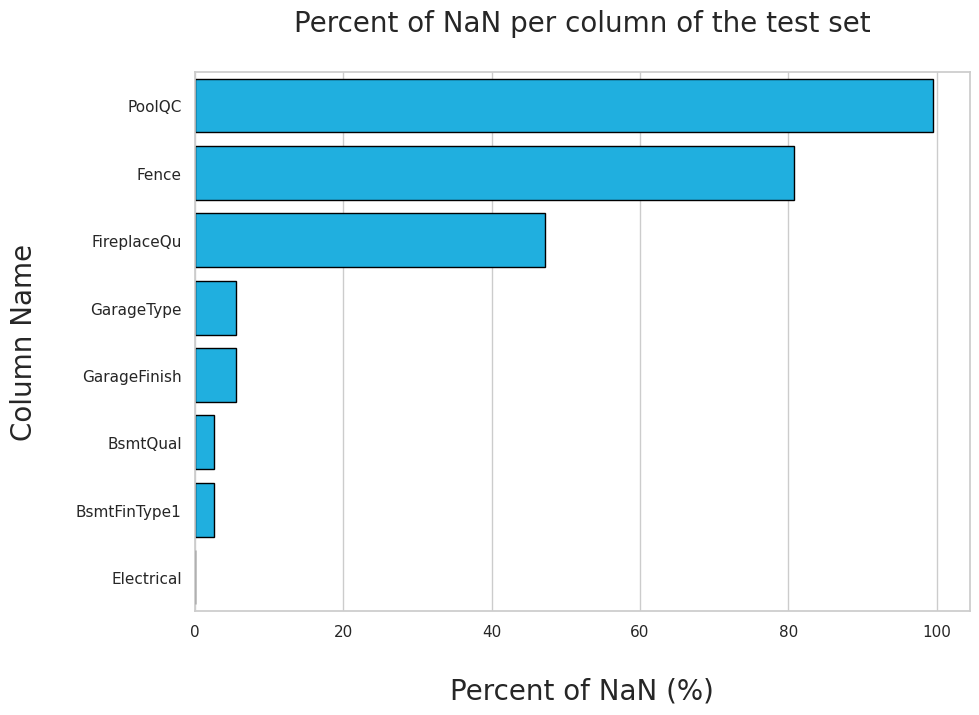

In [ ]:
# Check the NaN of the test set by ploting percent of missing values per column
column_with_nan = df_train_categ.columns[df_train_categ.isnull().any()]
column_name = []
percent_nan = []

for i in column_with_nan:
    column_name.append(i)
    percent_nan.append(
        round(df_train_categ[i].isnull().sum() * 100 / len(df_train_categ), 2))

tab = pd.DataFrame(column_name, columns=["Column"])
tab["Percent_NaN"] = percent_nan
tab.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)


# Define figure parameters
sns.set(rc={"figure.figsize": (10, 7)})
sns.set_style("whitegrid")

# Plot results
p = sns.barplot(x="Percent_NaN", y="Column", data=tab,
                edgecolor="black", color="deepskyblue")
p.set_title("Percent of NaN per column of the test set\n", fontsize=20)
p.set_xlabel("\nPercent of NaN (%)", fontsize=20)
p.set_ylabel("Column Name\n", fontsize=20)

In [ ]:
# Drop the features where the percentage of NaN is higher than 5%
df_train_categ.drop(["PoolQC", "Fence", "FireplaceQu", "GarageType", "GarageFinish"],
                    axis=1, inplace=True)

In [ ]:
# Fill the NaN of each feature by the corresponding modal class
categ_fill_null = {"BsmtQual": df_train_categ["BsmtQual"].mode().iloc[0],
                   "BsmtFinType1": df_train_categ["BsmtFinType1"].mode().iloc[0],
                   "Electrical": df_train_categ["Electrical"].mode().iloc[0]}

df_train_categ = df_train_categ.fillna(value=categ_fill_null)

Test Set

In [ ]:
# Drop the same features from test set as for the train set
df_test_categ.drop(["PoolQC", "Fence", "FireplaceQu",
                    "GarageType", "GarageFinish"], axis=1, inplace=True,)

Text(0, 0.5, 'Column Name\n')

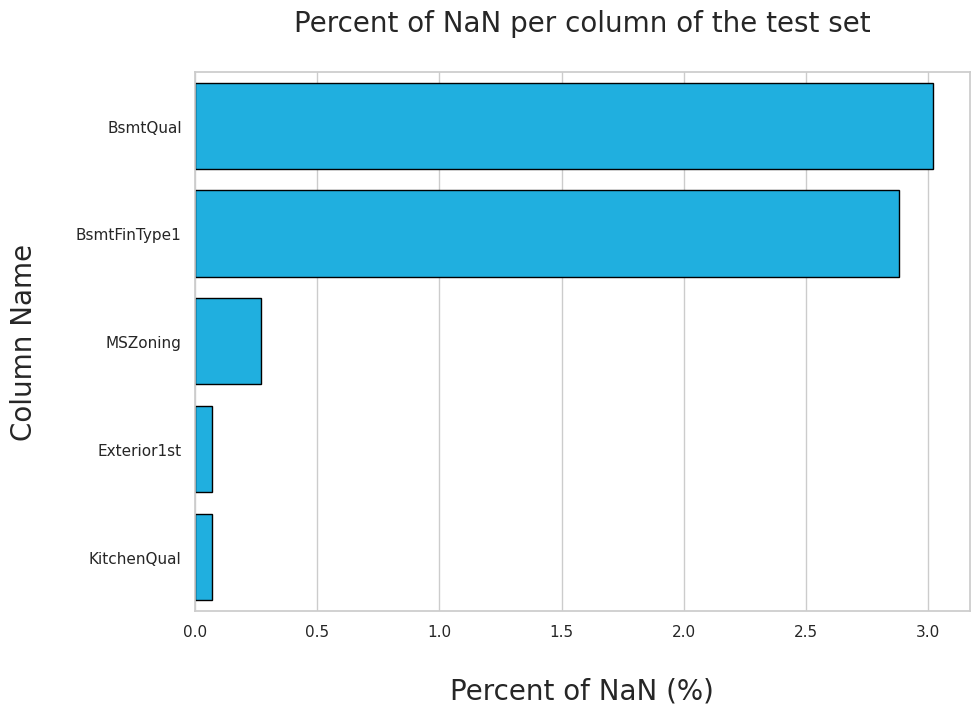

In [ ]:
# Check the NaN of the test set by ploting percent of missing values per column
column_with_nan = df_test_categ.columns[df_test_categ.isnull().any()]
column_name = []
percent_nan = []

for i in column_with_nan:
    column_name.append(i)
    percent_nan.append(
        round(df_test_categ[i].isnull().sum() * 100 / len(df_test_categ), 2))

tab = pd.DataFrame(column_name, columns=["Column"])
tab["Percent_NaN"] = percent_nan
tab.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)


# Define figure parameters
sns.set(rc={"figure.figsize": (10, 7)})
sns.set_style("whitegrid")

# Plot results
p = sns.barplot(x="Percent_NaN", y="Column", data=tab,
                edgecolor="black", color="deepskyblue")
p.set_title("Percent of NaN per column of the test set\n", fontsize=20)
p.set_xlabel("\nPercent of NaN (%)", fontsize=20)
p.set_ylabel("Column Name\n", fontsize=20)

In [ ]:
# Fill the NaN of each feature by the corresponding modal class
categ_fill_null = {"BsmtQual": df_test_categ["BsmtQual"].mode().iloc[0],
                   "BsmtFinType1": df_test_categ["BsmtFinType1"].mode().iloc[0],
                   "MSZoning": df_test_categ["MSZoning"].mode().iloc[0],
                   "Exterior1st": df_test_categ["Exterior1st"].mode().iloc[0],
                   "KitchenQual": df_test_categ["KitchenQual"].mode().iloc[0]}

df_test_categ = df_test_categ.fillna(value=categ_fill_null)

## I.3.3. Transform Categorical features into Binary features (get_dummies)

In [ ]:
# Train set
for i in df_train_categ.columns.tolist()[:-1]:
    df_dummies = pd.get_dummies(df_train_categ[i], prefix=i)

    # merge both tables
    df_train_categ = df_train_categ.join(df_dummies)

# Select the binary features only
df_train_binary = df_train_categ.iloc[:, 18:]
df_train_binary.head()

MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0                 0            0            0            1            0   
1                 0            0            0            1            0   
2                 0            0            0            1            0   
3                 0            0            0            1            0   
4                 0            0            0            1            0   

   LotShape_IR1  LotShape_IR2  LotShape_IR3  LotShape_Reg  LotConfig_Corner  \
0             0             0             0             1                 0   
1             0             0             0             1                 0   
2             1             0             0             0                 0   
3             1             0             0             0                 1   
4             1             0             0             0                 0   

   ...  KitchenQual_Ex  KitchenQual_Fa  KitchenQual_Gd  KitchenQual_TA  \
0  ...               0               0               1               0   
1  ...               0               0               0               1   
2  ...               0               0               1               0   
3  ...               0               0               1               0   
4  ...               0               0               1               0   

   SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
0                      0                      0                     0   
1                      0                      0                     0   
2                      0                      0                     0   
3                      1                      0                     0   
4                      0                      0                     0   

   SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                     0                     1                      0  
1                     0                     1                      0  
2                     0                     1                      0  
3                     0                     0                      0  
4                     0                     1                      0  

[5 rows x 122 columns]

In [ ]:
# Test set
for i in df_test_categ.columns.tolist():
    df_dummies = pd.get_dummies(df_test_categ[i], prefix=i)

    # merge both tables
    df_test_categ = df_test_categ.join(df_dummies)

# Select the binary features only
df_test_binary = df_test_categ.iloc[:, 17:]
df_test_binary.head()

MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0                 0            0            1            0            0   
1                 0            0            0            1            0   
2                 0            0            0            1            0   
3                 0            0            0            1            0   
4                 0            0            0            1            0   

   LotShape_IR1  LotShape_IR2  LotShape_IR3  LotShape_Reg  LotConfig_Corner  \
0             0             0             0             1                 0   
1             1             0             0             0                 1   
2             1             0             0             0                 0   
3             1             0             0             0                 0   
4             1             0             0             0                 0   

   ...  KitchenQual_Ex  KitchenQual_Fa  KitchenQual_Gd  KitchenQual_TA  \
0  ...               0               0               0               1   
1  ...               0               0               1               0   
2  ...               0               0               0               1   
3  ...               0               0               1               0   
4  ...               0               0               1               0   

   SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
0                      0                      0                     0   
1                      0                      0                     0   
2                      0                      0                     0   
3                      0                      0                     0   
4                      0                      0                     0   

   SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                     0                     1                      0  
1                     0                     1                      0  
2                     0                     1                      0  
3                     0                     1                      0  
4                     0                     1                      0  

[5 rows x 118 columns]

In [ ]:
# Let's check if the column headings are the same in both data set, df_train and df_test
dif_1 = [x for x in df_train_binary.columns if x not in df_test_binary.columns]
print(
    f"Features present in df_train_categ and absent in df_test_categ: {dif_1}\n")

dif_2 = [x for x in df_test_binary.columns if x not in df_train_binary.columns]
print(
    f"Features present in df_test_categ set and absent in df_train_categ: {dif_2}")

Features present in df_train_categ and absent in df_test_categ: ['HouseStyle_2.5Fin', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Electrical_Mix']

Features present in df_test_categ set and absent in df_train_categ: []


In [ ]:
# Let's drop these columns from df_train_binary
df_train_binary.drop(dif_1, axis=1, inplace=True)

# Check again if the column headings are the same in both data set
dif_1 = [x for x in df_train_binary.columns if x not in df_test_binary.columns]
print(
    f"Features present in df_train_categ and absent in df_test_categ: {dif_1}\n")

dif_2 = [x for x in df_test_binary.columns if x not in df_train_binary.columns]
print(
    f"Features present in df_test_categ set and absent in df_train_categ: {dif_2}")

Features present in df_train_categ and absent in df_test_categ: []

Features present in df_test_categ set and absent in df_train_categ: []


# I.4. Merge numerical and binary features into one data set

In [ ]:
# Add binary features to numreical features
# Train set
df_train_new = df_train_imputed.join(df_train_binary)
print(f"Train set: {df_train_new.shape}")

# Test set
df_test_new = df_test_imputed.join(df_test_binary)
print(f"Test set: {df_test_new.shape}")

Train set: (1460, 135)
Test set: (1459, 134)


## I.5. Drop outliers from the train set

In [ ]:
# Drop "WoodDeckSF" and "OpenPorchSF" --> See Numerical Features Viz
df_train_new.drop(["WoodDeckSF", "OpenPorchSF"], axis=1, inplace=True)
df_test_new.drop(["WoodDeckSF", "OpenPorchSF"], axis=1, inplace=True)

In [ ]:
# Let's handle the outliers in "GrLivArea", "TotalBsmtSF" and "GarageArea"
# Outliers in "GrLivArea"
outliers1 = df_train_new[(df_train_new["GrLivArea"] > 4000) & (
    df_train_new["SalePrice"] <= 200000)].index.tolist()

# Outliers in "TotalBsmtSF"
outliers2 = df_train_new[(df_train_new["TotalBsmtSF"] > 3000) & (
    df_train_new["SalePrice"] <= 400000)].index.tolist()

# Outliers in "GarageArea"
outliers3 = df_train_new[(df_train_new["GarageArea"] > 1200) & (
    df_train_new["SalePrice"] <= 300000)].index.tolist()

# List of all the outliers
outliers = outliers1 + outliers2 + outliers3
outliers = list(set(outliers))
print(outliers)

# Drop these outlier
df_train_new = df_train_new.drop(df_train_new.index[outliers])

# Reset index
df_train_new = df_train_new.reset_index().drop("index", axis=1)

[1061, 581, 1190, 523, 332, 1298]


# II. Feature engineering

In [ ]:
# Define a function to calculate the occupancy rate of the first floor of the total living area


def floor_occupation(x):
    """First floor occupation of the total live area

    floor_occupation equation has the following form:
    (1st Floor Area * 100) / (Ground Live Area)

    Args:
        x -- the corresponding feature

    Returns:
        0 -- if Ground Live Area = 0
        equation -- if Ground Live Area > 0
    """
    if x["GrLivArea"] == 0:
        return 0
    else:
        return x["1stFlrSF"] * 100 / x["GrLivArea"]


# Apply the function on train and test set
df_train_new["1stFlrPercent"] = df_train_new.apply(
    lambda x: floor_occupation(x), axis=1)

df_test_new["1stFlrPercent"] = df_test_new.apply(
    lambda x: floor_occupation(x), axis=1)

# Drop "1stFlrSF" and "2ndFlrSF"
df_train_new.drop(["1stFlrSF", "2ndFlrSF"], axis=1, inplace=True)
df_test_new.drop(["1stFlrSF", "2ndFlrSF"], axis=1, inplace=True)

In [ ]:
# Define a function to calculate the occupancy rate of the finished basement area


def bsmt_finish(x):
    """Propotion of finished area in basement

    bsmt_finish equation has the following form:
    (Finished Basement Area * 100) / (Total Basement Area)

    Args:
        x -- the corresponding feature

    Returns:
        0 -- if Total Basement Area = 0
        equation -- if Total Basement Area > 0
    """
    if x["TotalBsmtSF"] == 0:
        return 0
    else:
        return x["BsmtFinSF1"] * 100 / x["TotalBsmtSF"]


# Apply the function on train and test set
df_train_new["BsmtFinPercent"] = df_train_new.apply(
    lambda x: bsmt_finish(x), axis=1)

df_test_new["BsmtFinPercent"] = df_test_new.apply(
    lambda x: bsmt_finish(x), axis=1)

# Drop "BsmtFinSF1"
df_train_new.drop(["BsmtFinSF1"], axis=1, inplace=True)
df_test_new.drop(["BsmtFinSF1"], axis=1, inplace=True)

In [ ]:
# Convert Year of construction to Age of the house since the construction
df_train_new["AgeSinceConst"] = df_train_new["YearBuilt"].max() - df_train_new["YearBuilt"]

df_test_new["AgeSinceConst"] = df_test_new["YearBuilt"].max() - df_test_new["YearBuilt"]

# Drop "YearBuilt"
df_train_new.drop(["YearBuilt"], axis=1, inplace=True)
df_test_new.drop(["YearBuilt"], axis=1, inplace=True)

In [ ]:
df_train_new["AgeSinceRemod"] = df_train_new["YearRemodAdd"].max() - df_train_new["YearRemodAdd"]

df_test_new["AgeSinceRemod"] = df_test_new["YearRemodAdd"].max() - df_test_new["YearRemodAdd"]

# Drop "YearRemodAdd"
df_train_new.drop(["YearRemodAdd"], axis=1, inplace=True)
df_test_new.drop(["YearRemodAdd"], axis=1, inplace=True)

In [ ]:
continuous_features = ["OverallQual", "TotalBsmtSF", "GrLivArea",
                       "FullBath", "TotRmsAbvGrd", "GarageCars", "GarageArea",
                       "MasVnrArea", "Fireplaces", "1stFlrPercent",
                       "BsmtFinPercent", "AgeSinceConst", "AgeSinceRemod"]
df_skew_verify = df_train_new.loc[:, continuous_features]

In [ ]:
# Select features with absolute Skew higher than 0.5
skew_ft = []

for i in continuous_features:
    # list of skew for each corresponding feature
    skew_ft.append(abs(df_skew_verify[i].skew()))

df_skewed = pd.DataFrame({"Columns": continuous_features,
                          "Abs_Skew": skew_ft})

sk_features = df_skewed[df_skewed["Abs_Skew"] > 0.5]["Columns"].tolist()
print(f"List of skewed features: {sk_features}")

List of skewed features: ['GrLivArea', 'TotRmsAbvGrd', 'MasVnrArea', 'Fireplaces', 'AgeSinceConst', 'AgeSinceRemod']


In [ ]:
# Log transformation of the skewed features
#sf_features = ["TotalBsmtSF", "GrLivArea", "MasVnrArea", "GarageArea"]

for i in sk_features:
    # loop over i (features) to calculate Log of surfaces
    # Train set
    df_train_new[i] = np.log((df_train_new[i])+1)

    # Test set
    df_test_new[i] = np.log((df_test_new[i])+1)

# III. Preparing data for modeling

## III.1 Target variable 'SalePrice'

Text(0, 0.5, '')

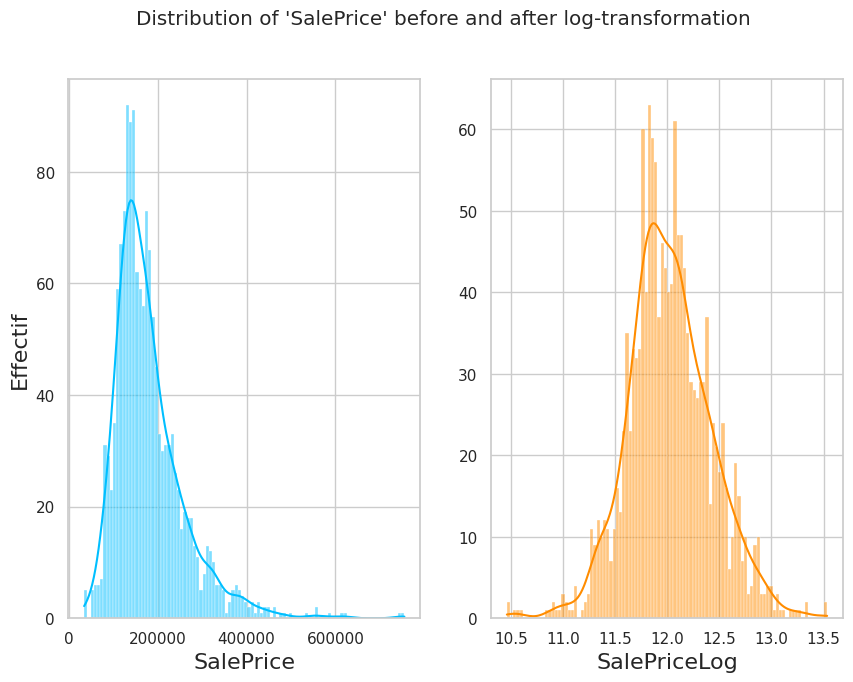

In [ ]:
# Log transformation of the target variable "SalePrice"
df_train_new["SalePriceLog"] = np.log(df_train_new.SalePrice)

# Plot the distribution before and after transformation
fig, axes = plt.subplots(1, 2)
fig.suptitle("Distribution of 'SalePrice' before and after log-transformation")

# before log transformation
p = sns.histplot(ax=axes[0], x=df_train_new["SalePrice"],
                 kde=True, bins=100, color="deepskyblue")
p.set_xlabel("SalePrice", fontsize=16)
p.set_ylabel("Effectif", fontsize=16)

# after log transformation
q = sns.histplot(ax=axes[1], x=df_train_new["SalePriceLog"],
                 kde=True, bins=100, color="darkorange")
q.set_xlabel("SalePriceLog", fontsize=16)
q.set_ylabel("", fontsize=16)

In [ ]:
# Drop the original SalePrice
df_train_new.drop(["SalePrice"], axis=1, inplace=True)

## III.2. Split data into train and test set and Standardization

In [ ]:
# Extract the features (X) and the target (y)
# Features (X)
X = df_train_new[[i for i in list(
    df_train_new.columns) if i != "SalePriceLog"]]
print(X.shape)

# Target (y)
y = df_train_new.loc[:, "SalePriceLog"]
print(y.shape)

(1454, 131)
(1454,)


In [ ]:
# Split into X_train and X_test (by stratifying on y)
# Stratify on a continuous variable by splitting it in bins
# Create the bins.
bins = np.linspace(0, len(y), 150)
y_binned = np.digitize(y, bins)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y_binned, shuffle=True)
print(f"X_train:{X_train.shape}\ny_train:{y_train.shape}")
print(f"\nX_test:{X_test.shape}\ny_test:{y_test.shape}")

X_train:(1163, 131)
y_train:(1163,)

X_test:(291, 131)
y_test:(291,)


In [ ]:
# Standardize the data
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)
# The same standardization is applied for df_test_new
df_test_new = std_scale.transform(df_test_new)


# The output of standardization is a vector. Let's turn it into a table
# Convert X, y and test data into dataframe
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
df_test_new = pd.DataFrame(df_test_new, columns=X.columns)

y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index().drop("index", axis=1)

y_test = pd.DataFrame(y_test)
y_test = y_test.reset_index().drop("index", axis=1)

## III.3. Backward Stepwise Regression

In [ ]:
Selected_Features = []


def backward_regression(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05, verbose=True):
    """To select feature with Backward Stepwise Regression

    Args:
        X -- features values
        y -- target variable
        initial_list -- features header
        threshold_in -- pvalue threshold of features to keep
        threshold_out -- pvalue threshold of features to drop
        verbose -- true to produce lots of logging output

    Returns:
        list of selected features for modeling
    """
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    Selected_Features.append(included)
    print(f"\nSelected Features:\n{Selected_Features[0]}")


# Application of the backward regression function on our training data
backward_regression(X_train, y_train)

worst_feature : 1stFlrPercent, 0.9968151378934613 
worst_feature : Exterior1st_HdBoard, 0.9920098679643454 
worst_feature : Neighborhood_Blmngtn, 0.9797599929313379 
worst_feature : Neighborhood_Sawyer, 0.9729617317045096 
worst_feature : AgeSinceConst, 0.9668603525880315 
worst_feature : Condition1_RRAn, 0.9390916268444518 
worst_feature : Foundation_Slab, 0.9098394436379893 
worst_feature : Foundation_CBlock, 0.9547792232097498 
worst_feature : Foundation_PConc, 0.954855516394935 
worst_feature : Electrical_FuseP, 0.9969206125567658 
worst_feature : RoofStyle_Gable, 0.9092507786777582 
worst_feature : LotConfig_Corner, 0.9009828627852043 
worst_feature : HouseStyle_SFoyer, 0.8955490358146336 
worst_feature : RoofStyle_Hip, 0.9001659779883965 
worst_feature : LotConfig_FR3, 0.8739090986812111 
worst_feature : Neighborhood_Blueste, 0.8745858852744237 
worst_feature : RoofStyle_Flat, 0.8676177718979863 
worst_feature : Condition1_PosA, 0.8628361043293195 
worst_feature : BsmtFinType1_Re

In [ ]:
# Keep the selected features only
X_train = X_train.loc[:, Selected_Features[0]]
X_test = X_test.loc[:, Selected_Features[0]]
df_test_new = df_test_new.loc[:, Selected_Features[0]]

## III.4. Variance Inflation Factor

In [ ]:
# Here I calculate VIF for each feature
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    X_train.values, i) for i in range(X_train.shape[1])]

# VIF results in a table
vif["features"] = X_train.columns
vif.round(1)

VIF Factor               features
0         3.60            OverallQual
1         1.90            TotalBsmtSF
2         2.20              GrLivArea
3         5.60             GarageCars
4         5.30             GarageArea
5         1.60             Fireplaces
6         1.10       MSZoning_C (all)
7         2.20            MSZoning_RM
8         1.10           LotShape_IR2
9         1.00           LotShape_IR3
10        1.10      LotConfig_CulDSac
11        1.40   Neighborhood_BrkSide
12        1.10   Neighborhood_ClearCr
13        1.20   Neighborhood_Crawfor
14        1.20   Neighborhood_Edwards
15        1.20   Neighborhood_NoRidge
16        1.60   Neighborhood_NridgHt
17        2.10   Neighborhood_OldTown
18        1.10   Neighborhood_StoneBr
19        1.10   Neighborhood_Veenker
20        1.10        Condition1_Norm
21        1.20        BldgType_Duplex
22        1.30         BldgType_Twnhs
23        1.40        BldgType_TwnhsE
24        1.10    Exterior1st_AsbShng
25        1.10    Exterior1st_BrkComm
26        1.20    Exterior1st_BrkFace
27        1.20    Exterior1st_Wd Sdng
28        1.50      Foundation_BrkTil
29        1.00        Foundation_Wood
30        1.70            BsmtQual_Ex
31        1.90            BsmtQual_TA
32        1.10       BsmtFinType1_LwQ
33        3.30       BsmtFinType1_Unf
34        2.30           HeatingQC_Ex
35        1.30           HeatingQC_Fa
36        2.10           HeatingQC_TA
37       70.40       Electrical_FuseA
38       23.90       Electrical_FuseF
39       90.40       Electrical_SBrkr
40        1.50         KitchenQual_Ex
41        1.50         KitchenQual_Fa
42        2.30         KitchenQual_TA
43        2.10  SaleCondition_Abnorml
44        1.20   SaleCondition_Alloca
45        1.30   SaleCondition_Family
46        2.50   SaleCondition_Normal
47        3.00         BsmtFinPercent
48        2.70          AgeSinceRemod

In [ ]:
# Select features with high VIF
high_vif_list = vif[vif["VIF Factor"] > 10]["features"].tolist()

if len(high_vif_list) == 0:
    # print empty list if low multicolinearity
    print(f"None of the features have a high multicollinearity")
else:
    # print list of features with high multicolinearity
    print(f"List of features with high multicollinearity: {high_vif_list}")

List of features with high multicollinearity: ['Electrical_FuseA', 'Electrical_FuseF', 'Electrical_SBrkr']


In [ ]:
# Drop features with high multicollinearity from X_train, X_test and df_test_new
X_train.drop(high_vif_list, axis=1, inplace=True)

X_test.drop(high_vif_list, axis=1, inplace=True)

df_test_new.drop(high_vif_list, axis=1, inplace=True)

## III.5. Cook distance

In [ ]:
X_constant = sm.add_constant(X_train)

model = sm.OLS(y_train, X_constant)
lr = model.fit()

# Cook distance
np.set_printoptions(suppress=True)

# Create an instance of influence
influence = lr.get_influence()

# Get Cook's distance for each observation
cooks = influence.cooks_distance

# Result as a dataframe
cook_df = pd.DataFrame({"Cook_Distance": cooks[0], "p_value": cooks[1]})
cook_df.head()

Cook_Distance  p_value
0           0.00     1.00
1           0.00     1.00
2           0.00     1.00
3           0.00     1.00
4           0.00     1.00

In [ ]:
# Remove the influential observation from X_train and y_train
influent_observation = cook_df[cook_df["p_value"] < 0.05].index.tolist()
print(f"Influential observations dropped: {influent_observation}")

# Drop these obsrevations
X_train = X_train.drop(X_train.index[influent_observation])
y_train = y_train.drop(y_train.index[influent_observation])

Influential observations dropped: []


# IV. Modeling

## IV.1. Models and metrics selection

In [ ]:
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
# Let's define a function for each metrics
# R²
def rsqr_score(test, pred):
    """Calculate R squared score

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        R squared score
    """
    r2_ = r2_score(test, pred)
    return r2_


# RMSE
def rmse_score(test, pred):
    """Calculate Root Mean Square Error score

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        Root Mean Square Error score
    """
    rmse_ = np.sqrt(mean_squared_error(test, pred))
    return rmse_


# Print the scores
def print_score(test, pred):
    """Print calculated score

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        print the regressor name
        print the R squared score
        print Root Mean Square Error score
    """

    print(f"- Regressor: {regr.__class__.__name__}")
    print(f"R²: {rsqr_score(test, pred)}")
    print(f"RMSE: {rmse_score(test, pred)}\n")

In [ ]:
# Define regression models
dtr =  DecisionTreeRegressor()
ridge = Ridge()
lasso = Lasso(alpha=0.001)
elastic = ElasticNet(alpha=0.001)
rdf = RandomForestRegressor()
xgboost = XGBRegressor()
lgbm = LGBMRegressor()

# Train models on X_train and y_train
for regr in [dtr, ridge, lasso, elastic, rdf, xgboost, lgbm]:
    # fit the corresponding model
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    # Print the defined metrics above for each classifier
    print_score(y_test, y_pred)

- Regressor: DecisionTreeRegressor
R²: 0.694309455315473
RMSE: 0.2180041443175694

- Regressor: Ridge
R²: 0.8799283924557856
RMSE: 0.13662932079700812

- Regressor: Lasso
R²: 0.882161495317299
RMSE: 0.13535283552250307

- Regressor: ElasticNet
R²: 0.8811113375138949
RMSE: 0.1359546190984206

- Regressor: RandomForestRegressor
R²: 0.8711924682071074
RMSE: 0.14151236074559712

- Regressor: XGBRegressor
R²: 0.8535751604459753
RMSE: 0.15087980887721095

- Regressor: LGBMRegressor
R²: 0.8541915145011274
RMSE: 0.15056192069829796



## IV.2. Hyperparameters tuning and model optimization

### IV.2.1. Ridge regression

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters
alphas = np.logspace(-5, 5, 50).tolist()

tuned_parameters = {"alpha": alphas}

# GridSearch
ridge_cv = GridSearchCV(Ridge(), tuned_parameters, cv=10, n_jobs=-1, verbose=1)

# fit the GridSearch on train set
ridge_cv.fit(X_train, y_train)

# print best params and the corresponding R²
print(f"Best hyperparameters: {ridge_cv.best_params_}")
print(f"Best R² (train): {ridge_cv.best_score_}")

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best hyperparameters: {'alpha': 54.286754393238596}
Best R² (train): 0.9028976077549513


In [ ]:
# Ridge Regressor with the best hyperparameters
ridge_mod = Ridge(alpha=ridge_cv.best_params_["alpha"])

# Fit the model on train set
ridge_mod.fit(X_train, y_train)

# Predict on test set
y_pred = ridge_mod.predict(X_test)

print(f"- {ridge_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred)}")
print(f"RMSE: {rmse_score(y_test, y_pred)}")

- Ridge
R²: 0.8803048992902271
RMSE: 0.13641493929643758


In [ ]:
# Save the model results into lists
model_list = []
r2_list = []
rmse_list = []

model_list.append(ridge_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred), 4))
rmse_list.append(round(rmse_score(y_test, y_pred), 4))

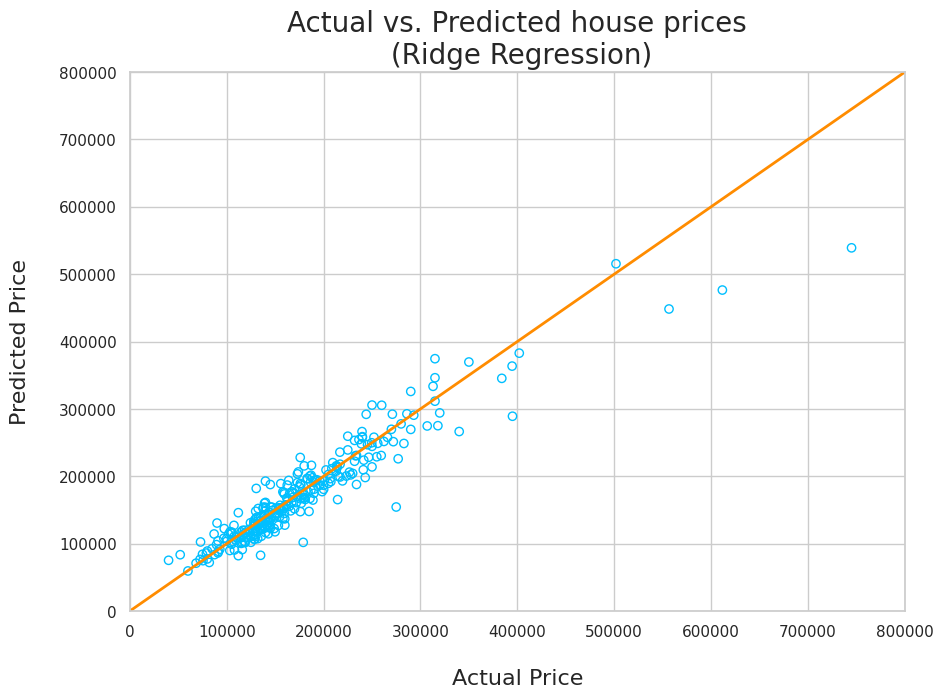

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Actual vs. Predicted house prices
actual_price = np.exp(y_test["SalePriceLog"])
predicted_price = np.exp(y_pred)

plt.figure()
plt.title("Actual vs. Predicted house prices\n (Ridge Regression)", fontsize=20)
plt.scatter(actual_price, predicted_price, color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()


### IV.2.2. Lasso regression

In [ ]:
from sklearn.linear_model import Lasso

# Define hyperparameters
tuned_parameters = {"alpha": [0.1, 1.0, 10.0],
                    "max_iter": [1000, 5000]}

# GridSearch
lasso_cv = GridSearchCV(estimator=Lasso(),
                        param_grid=tuned_parameters,
                        cv=5,
                        n_jobs=-1,
                        verbose=1)

# fit the GridSearch on train set
lasso_cv.fit(X_train, y_train)

# print best params and the corresponding R²
print(f"Best hyperparameters: {lasso_cv.best_params_}\n")
print(f"Best R²: {lasso_cv.best_score_}")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best hyperparameters: {'alpha': 0.1, 'max_iter': 1000}

Best R²: 0.7255955883715467


In [ ]:
from sklearn.linear_model import Lasso

# Lasso Regressor with the best hyperparameters
lasso_mod = Lasso(alpha=lasso_cv.best_params_["alpha"],
                  max_iter=lasso_cv.best_params_["max_iter"])

# Fit the model on train set
lasso_mod.fit(X_train, y_train)

# Predict on test set
y_pred = lasso_mod.predict(X_test)

print(f"- {lasso_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred)}")
print(f"RMSE: {rmse_score(y_test, y_pred)}")


- Lasso
R²: 0.7141284431878088
RMSE: 0.21081874334174827


In [ ]:
# Save the model results into lists
model_list.append(lasso_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred), 4))
rmse_list.append(round(rmse_score(y_test, y_pred), 4))

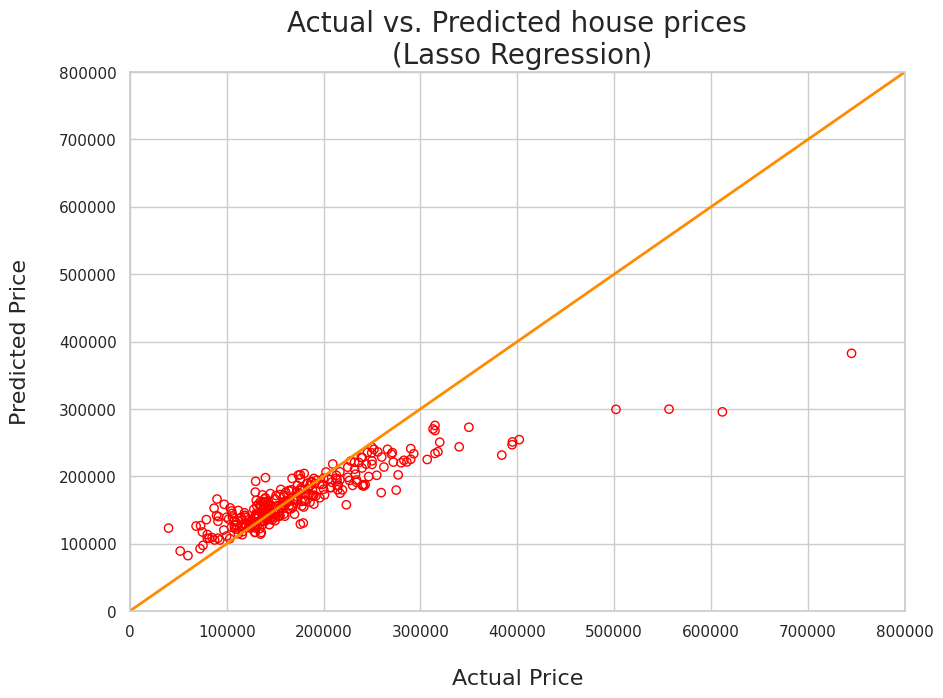

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Actual vs. Predicted house prices
actual_price = np.exp(y_test["SalePriceLog"])
predicted_price = np.exp(y_pred)

plt.figure()
plt.title("Actual vs. Predicted house prices\n (Lasso Regression)", fontsize=20)
plt.scatter(actual_price, predicted_price, color="red", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()


### IV.2.3. XGBoost regression

In [ ]:
# Define hyperparameters
tuned_parameters = {"max_depth": [3],
                    "colsample_bytree": [0.3, 0.7],
                    "learning_rate": [0.01, 0.05, 0.1],
                    "n_estimators": [100, 500]}

# GridSearch
xgbr_cv = GridSearchCV(estimator=XGBRegressor(),
                       param_grid=tuned_parameters,
                       cv=5,
                       n_jobs=-1,
                       verbose=1)

# fit the GridSearch on train set
xgbr_cv.fit(X_train, y_train)

# print best params and the corresponding R²
print(f"Best hyperparameters: {xgbr_cv.best_params_}\n")
print(f"Best R²: {xgbr_cv.best_score_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters: {'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}

Best R²: 0.8962107484195052


In [ ]:
# XGB Regressor with the best hyperparameters
xgbr_mod = XGBRegressor(seed=20,
                        colsample_bytree=xgbr_cv.best_params_["colsample_bytree"],
                        learning_rate=xgbr_cv.best_params_["learning_rate"],
                        max_depth=xgbr_cv.best_params_["max_depth"],
                        n_estimators=xgbr_cv.best_params_["n_estimators"])

# Fit the model on train set
xgbr_mod.fit(X_train, y_train)

# Predict on test set
y_pred = xgbr_mod.predict(X_test)

print(f"- {xgbr_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred)}")
print(f"RMSE: {rmse_score(y_test, y_pred)}")

- XGBRegressor
R²: 0.8854100611304199
RMSE: 0.1334740967979316


In [ ]:
# Save the model results into lists
model_list.append(xgbr_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred), 4))
rmse_list.append(round(rmse_score(y_test, y_pred), 4))

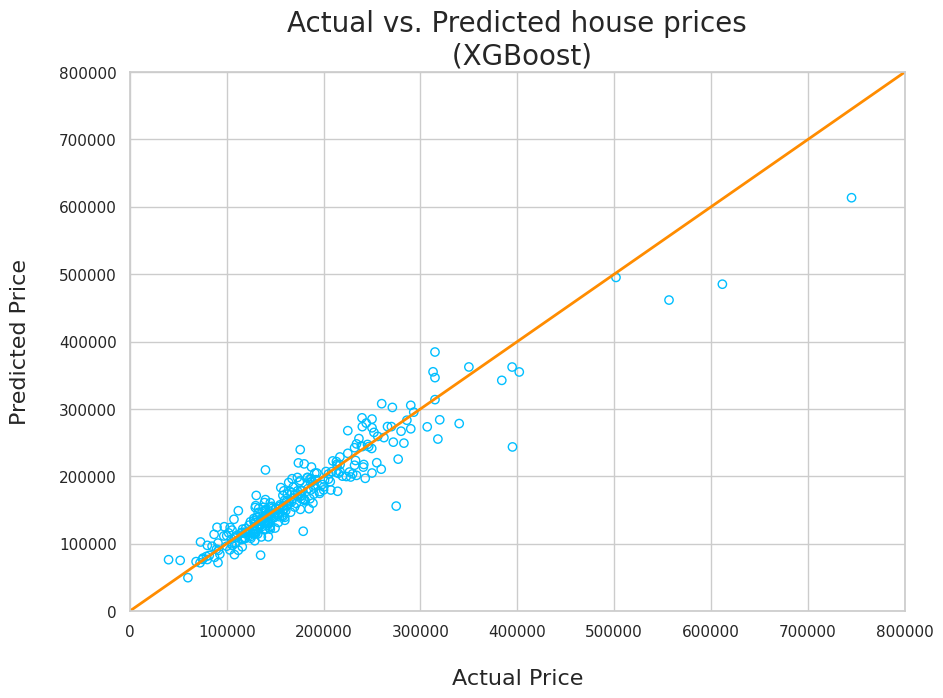

In [ ]:
# Plot Actual vs. Predicted house prices
actual_price = np.exp(y_test["SalePriceLog"])
predicted_price = np.exp(y_pred)

plt.figure()
plt.title("Actual vs. Predicted house prices\n (XGBoost)", fontsize=20)
plt.scatter(actual_price, predicted_price,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

### IV.2.4. LightGBM regression

In [ ]:
#Define hyperparameter
tuned_parameters = {"max_depth":[3,6,10], "learning_rate":[
      0.01,0.05,0.1], "n_estimators":[100.500,1000],}

#GridSearch
lgbm_cv = GridSearchCV(estimator=LGBMRegressor(
), param_grid=tuned_parameters, cv=10,n_jobs=-1,verbose=1)

# fit the GridSearch on train set
lgbm_cv.fit(X_train, y_train)

#print best params and the corresponding R2
print(f"Best hyperparameters:{lgbm_cv.best_params_}\n")
print(f"Best R2:{lgbm_cv.best_score_}")

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best hyperparameters:{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000}

Best R2:0.8844522298100939


In [ ]:
#LGBM Regressor with the best hyperparameters
lgbm_mod = LGBMRegressor(learning_rate=lgbm_cv.best_params_["learning_rate"],
                         max_depth=lgbm_cv.best_params_["max_depth"],
                         n_estimators=lgbm_cv.best_params_["n_estimators"])

# fit the model on train set
lgbm_mod.fit(X_train, y_train)

# Predict on test set
y_pred = lgbm_mod.predict(X_test)

print(f"-{lgbm_mod.__class__.__name__}")
print(f"R2: {rsqr_score(y_test,y_pred)}")
print(f"RMSE: {rmse_score(y_test,y_pred)}")

-LGBMRegressor
R2: 0.8543705338449332
RMSE: 0.1504694645754178


In [ ]:
# save the model result into list
model_list.append(lgbm_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred),4))
rmse_list.append(round(rmse_score(y_test, y_pred),4))

<function matplotlib.pyplot.show(close=None, block=None)>

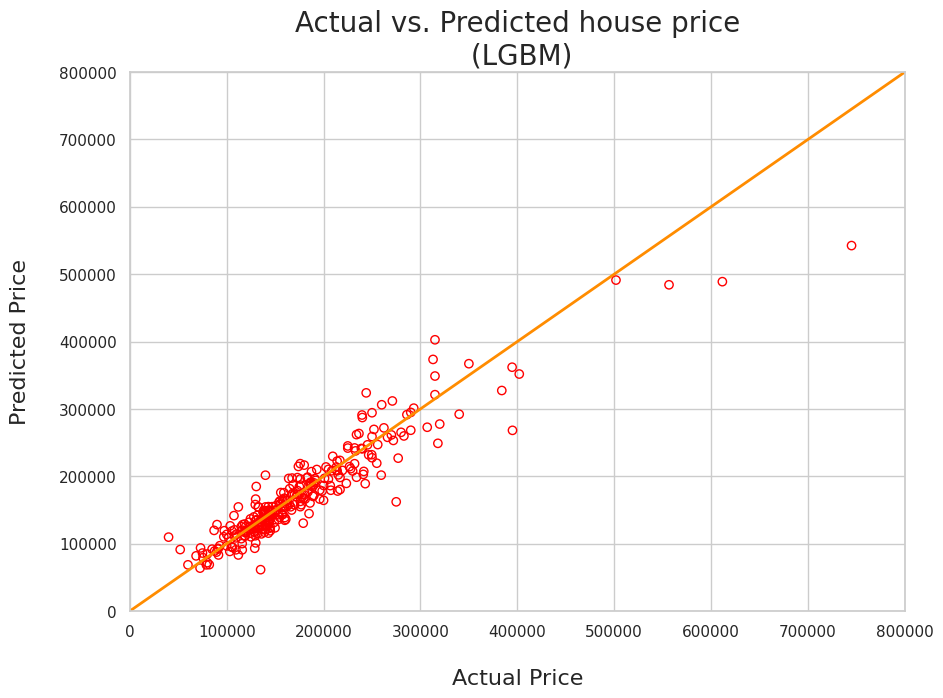

In [ ]:
#plot Actual vs. Predicted house price
actual_price = np.exp(y_test["SalePriceLog"])
predicted_price = np.exp(y_pred)

plt.figure()
plt.title("Actual vs. Predicted house price\n (LGBM)",fontsize=20)
plt.scatter(actual_price,predicted_price,
            color="red",marker="o", facecolors="none")
plt.plot([0,800000],[0,800000], "darkorange",lw=2)
plt.xlim(0,800000)
plt.ylim(0,800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n",fontsize=16)
plt.show

## IV.3. Choosing the best model

In [ ]:
#Create a table with pd.DataFrame
model_results = pd.DataFrame({"Model": model_list,
                            "R2":r2_list,
                            "RMSE": rmse_list})

model_results

Model   R2  RMSE
0          Ridge 0.88  0.14
1  LGBMRegressor 0.85  0.15

## IV.4. Prediction on 'House Prices-Advanced Regression Techniques' test data set

In [ ]:
#Prediction from XGBoost model
predictions_list = xgbr_mod.predict(df_test_new)

#conversion of logarithmic prediction to logical data sale price
saleprice_preds = np.exp(predictions_list)

#DataFrame of test ID and their corresponding prediction
output = pd.DataFrame({"Id": Id_test_list,
                       "Saleprice": saleprice_preds})
output.head(10)

Id  Saleprice
0  1461 121,690.72
1  1462 155,339.05
2  1463 178,467.06
3  1464 188,431.72
4  1465 192,232.33
5  1466 169,485.16
6  1467 167,202.88
7  1468 162,103.56
8  1469 192,896.02
9  1470 121,716.13

In [ ]:
# Prediction from LGBM model
predictions_list = lgbm_mod.predict(df_test_new)

# Conversion of logarithmic prediction to logical data sale price
saleprice_preds = np.exp(predictions_list)

# DataFrame of test ID and their corresponding prediction
output = pd.DataFrame({"Id": Id_test_list,
                       "Saleprice": saleprice_preds})
output.head(10)


Id  Saleprice
0  1461 125,610.07
1  1462 148,403.03
2  1463 175,063.87
3  1464 188,098.36
4  1465 197,398.71
5  1466 176,127.68
6  1467 170,917.05
7  1468 169,076.06
8  1469 179,678.96
9  1470 120,851.87

In [ ]:
# Prediction from lasso model
predictions_list = lasso_mod.predict(df_test_new)

# Conversion of logarithmic prediction to logical data sale price
saleprice_preds = np.exp(predictions_list)

# DataFrame of test ID and their corresponding prediction
output = pd.DataFrame({"Id": Id_test_list,
                       "Saleprice": saleprice_preds})
output.head(10)


Id  Saleprice
0  1461 132,175.79
1  1462 158,993.86
2  1463 154,099.54
3  1464 169,657.71
4  1465 202,208.06
5  1466 168,592.81
6  1467 159,669.51
7  1468 163,287.35
8  1469 185,042.03
9  1470 120,404.90